# First test of using a Transformer decoder only

Good guide: https://cameronrwolfe.substack.com/p/decoder-only-transformers-the-workhorse

pytorch api: https://pytorch.org/docs/stable/nn.html#transformer-layers

# 0 imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from data_preperation import dataset_snapshot

import math
import numpy as np

import random

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1 Data Preperation

## Special Tokens definieren

In [3]:
# SOS und EOS Tokens definieren

# Define SOS and EOS tokens as global variables
SOS_TOKEN = np.full((1, 12), 1)  # SOS token representation with 1
EOS_TOKEN = np.full((1, 12), 3)  # EOS token probably not neccessary since i use fixed length sequences

UNK_IDX = 5 #Brauchen wir glaube ich nicht
PAD_IDX = 4 #Brauchen wir auch nicht, weil die sequenzen alle genau richtig lang sind

## load dataset

In [4]:
# Create snapshots
dataset_as_snapshots = dataset_snapshot.process_dataset_multithreaded("/home/falaxdb/Repos/minus1/datasets/maestro_v3_split/hands_split_into_seperate_midis", 0.1)
# filter snapshots to 88 piano notes
dataset_as_snapshots = dataset_snapshot.filter_piano_range(dataset_as_snapshots)
# compress data into one octave
dataset_as_snapshots =  dataset_snapshot.compress_existing_dataset_to_12keys(dataset_as_snapshots)

for song in dataset_as_snapshots:
    print("song:")
    for track in song:
        print(track.shape)

Processed dataset (1038/1038): 100%|██████████| 1038/1038 [00:10<00:00, 102.06it/s]


Processed 1038 of 1038 files
song:
(1083, 12)
(1083, 12)
song:
(752, 12)
(752, 12)
song:
(2730, 12)
(2730, 12)
song:
(3707, 12)
(3707, 12)
song:
(1432, 12)
(1432, 12)
song:
(2220, 12)
(2220, 12)
song:
(2981, 12)
(2981, 12)
song:
(3479, 12)
(3479, 12)
song:
(1837, 12)
(1837, 12)
song:
(3464, 12)
(3464, 12)
song:
(601, 12)
(601, 12)
song:
(3805, 12)
(3805, 12)
song:
(2604, 12)
(2604, 12)
song:
(1082, 12)
(1082, 12)
song:
(5764, 12)
(5764, 12)
song:
(862, 12)
(862, 12)
song:
(1328, 12)
(1328, 12)
song:
(1926, 12)
(1926, 12)
song:
(5279, 12)
(5279, 12)
song:
(5355, 12)
(5355, 12)
song:
(7677, 12)
(7677, 12)
song:
(1778, 12)
(1778, 12)
song:
(2175, 12)
(2175, 12)
song:
(3741, 12)
(3741, 12)
song:
(7862, 12)
(7862, 12)
song:
(2767, 12)
(2767, 12)
song:
(7165, 12)
(7165, 12)
song:
(989, 12)
(989, 12)
song:
(10855, 12)
(10855, 12)
song:
(2716, 12)
(2716, 12)
song:
(2876, 12)
(2876, 12)
song:
(4344, 12)
(4344, 12)
song:
(3362, 12)
(3362, 12)
song:
(1363, 12)
(1363, 12)
song:
(3530, 12)
(3530, 1

## Daten batchen, splitten, etc

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


# Function to add SOS and EOS tokens to each chunk
def add_sos_eos_to_chunks(chunks):
    new_chunks = []
    for chunk in chunks:
        # new_chunk = np.vstack([SOS_TOKEN, chunk, EOS_TOKEN]) eos token probably not neccessary
        new_chunk = np.vstack([SOS_TOKEN, chunk])
        new_chunks.append(new_chunk)
    return new_chunks

# Function to split sequences into chunks
def split_into_chunks(sequence, chunk_size):
    return [sequence[i:i + chunk_size] for i in range(0, len(sequence), chunk_size)]

# Function to filter out short chunks while maintaining pairs
def filter_short_chunks(chunks_1, chunks_2, min_length):
    filtered_chunks_1 = []
    filtered_chunks_2 = []
    for chunk_1, chunk_2 in zip(chunks_1, chunks_2):
        if len(chunk_1) >= min_length and len(chunk_2) >= min_length:
            filtered_chunks_1.append(chunk_1)
            filtered_chunks_2.append(chunk_2)
    return filtered_chunks_1, filtered_chunks_2

# Custom Dataset class
class PianoDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Prepare the dataset with paired sequences and SOS/EOS tokens for each chunk
def prepare_dataset(dataset_as_snapshots, chunk_size, min_length):
    data = []
    for song in dataset_as_snapshots:
        track_1, track_2 = song
        assert len(track_1) == len(track_2), "Tracks must have the same length"
        
        chunks_1 = split_into_chunks(track_1, chunk_size)
        chunks_2 = split_into_chunks(track_2, chunk_size)
        chunks_1, chunks_2 = filter_short_chunks(chunks_1, chunks_2, min_length)
        
        # Add SOS and EOS tokens to each chunk
        chunks_1 = add_sos_eos_to_chunks(chunks_1)
        chunks_2 = add_sos_eos_to_chunks(chunks_2)
        
        for x, y in zip(chunks_1, chunks_2):
            data.append((x, y))
    return data


In [6]:
# Define your dataset parameters
chunk_size = 100  # Define the chunk size you want
min_length = chunk_size  # Minimum length to keep a chunk
batch_size = 32


# Prepare the dataset
data = prepare_dataset(dataset_as_snapshots, chunk_size, min_length)

# Split the dataset using sklearn while maintaining pairs
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Create custom datasets
train_dataset = PianoDataset(train_data)
val_dataset = PianoDataset(val_data)
test_dataset = PianoDataset(test_data)

# Create DataLoaders for each subset with drop_last=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Iterate over the DataLoader (example with train_loader)
for batch in train_loader:
    X, y = batch
    print(X.shape, y.shape)
    # X and y should both have shape (batch_size, chunk_size + 2, feature dimension) because of SOS and EOS tokens

torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([32, 101, 12]) torch.Size([32, 101, 12])
torch.Size([

# 2. Modell definieren

## Positional encoding

In [7]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Info
        self.dropout = nn.Dropout(p=dropout)
        
        # Encoding - From formula -> This is basically applying the formula for Positional encoding (The one with Sinus and Cosinus)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Baically a positions list 0, 1, 2, 3, 4, 5, ...
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 1000^(2i/dim_model)
        
        # # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        
        #  # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pe[:, 1::2] = torch.cos(position * div_term)
        
         # Saving buffer (same as parameter without gradients needed)
        # pe = pe.unsqueeze(0).transpose(0, 1)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (1, max_len, d_model) Änderung evtl. wegen batch first = True
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        # Residual connection + pos encoding
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Maske

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]
    
    return mask

# Die Funktion create_mask erstellt sowohl Quell- als auch Ziel-Pad-Masken, indem sie prüft, ob Elemente in der Quell- und Zielsequenz gleich dem Pad-Token sind. Diese Masken werden transponiert, um die richtige Dimension zu erhalten.
def create_mask(tgt):
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    return tgt_mask

## Transformer

In [9]:
class TransformerDecoderModel(nn.Module):
    def __init__(self, input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout=0.1, max_len=5000):
        super(TransformerDecoderModel, self).__init__()
        self.model_type = 'Transformer'
        
        # Hier werden die Layers des modells definiert
        
        # Input token werden zu embedding vektoren umgewandelt -> hier einfach mit linearer schicht
        # input dimension wird zu embed_dim transformiert. embed dim ist die dimension meiner embeddings
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional encoding schicht für infos zu reihenfolge
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        
        # hier werden die Decoder layers und der stack an layers (der transformer definiert)
        decoder_layers = nn.TransformerDecoderLayer(embed_dim, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)
        
        # output schicht, um die wahrscheinlichkeit für die einzelnen Tokens festzulegen
        self.generator = nn.Linear(embed_dim, input_dim)
        
        # Sigmoid für zwischen 0 und 1 
        self.sigmoid = nn.Sigmoid()

    def forward(self, tgt, memory, tgt_mask,):
        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)  # Apply positional encoding
        
        # memory muss auch korrekt eingebettet/pos encoded werden werden
        memory = self.embedding(memory)
        memory = self.pos_encoder(memory)
        
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        output = self.generator(output)
        
        output = self.sigmoid(output)
        return output

# 3 Modell Laden und hyperparamter festlegen

hyperparameter

In [10]:
# Hyperparameters
input_dim = 12 # Dimension der eingehenden tokens
embed_dim = 64  # Embedding dimension
nhead = 2 # anzahl der attention heads
num_decoder_layers = 2 # anzahl der decoder layer (die Blöcke übereinander)
dim_feedforward = 128 # dimension des feedforward neural nets
dropout = 0.1
# batch_size = 32 oben festgelegt
num_epochs = 10
learning_rate = 0.001
max_len = 200  # Maximum length of the sequences -> abbruch ohne end token

modell initialisieren + Optimizer und Kostenfunktion

In [11]:
from lstm_training import music_theory_loss

# Modell initialisieren
model = TransformerDecoderModel(input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout, max_len)
# auf GPU laden
model = model.to(DEVICE)

# Kostenfunktion festlegen 
loss_fn = nn.BCELoss()

# optimizer festlegen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 4 Trainings und validation loop

for debugging

In [12]:
def debug_shapes_and_ranges(X, y, output):
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Output shape:", output.shape)
    print("Output range:", torch.min(output).item(), torch.max(output).item())
    print("y range:", torch.min(y).item(), torch.max(y).item())

In [13]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch
        #print(X.shape, y.shape)
        # X and y should both have shape (batch_size, chunk_size + 2, feature dim) because of SOS and EOS tokens
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1, :]
        y_expected = y[:,1:, :]
        #print("Training: X shape:", X.shape)
        #print("Training: y_input shape:", y_input.shape)
        #print("Training: y_expected shape:", y_expected.shape)
        
        # Get mask to mask out the next words
        tgt_mask = create_mask(y_input).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(y_input, X, tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        # Debug shapes and ranges
        # debug_shapes_and_ranges(X, y, logits)
        
        # Calculate the loss
        loss = loss_fn(logits, y_expected)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [14]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1, :]
        y_expected = y[:,1:, :]
        
        # Get mask to mask out the next words
        tgt_mask = create_mask(y_input).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(y_input, X, tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        
        # Calculate the loss
        loss = loss_fn(logits, y_expected)
        
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

# 5 Modell trainieren

In [15]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_loop(model, optimizer, loss_fn, train_loader)
    end_time = timer()
    val_loss = validation_loop(model, loss_fn, val_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.191, Val loss: 0.155, Epoch time = 6.430s
Epoch: 2, Train loss: 0.154, Val loss: 0.152, Epoch time = 2.488s
Epoch: 3, Train loss: 0.152, Val loss: 0.150, Epoch time = 1.718s
Epoch: 4, Train loss: 0.150, Val loss: 0.149, Epoch time = 6.033s
Epoch: 5, Train loss: 0.149, Val loss: 0.148, Epoch time = 5.931s
Epoch: 6, Train loss: 0.148, Val loss: 0.147, Epoch time = 3.718s
Epoch: 7, Train loss: 0.148, Val loss: 0.147, Epoch time = 3.501s
Epoch: 8, Train loss: 0.147, Val loss: 0.147, Epoch time = 5.789s
Epoch: 9, Train loss: 0.147, Val loss: 0.146, Epoch time = 5.908s
Epoch: 10, Train loss: 0.147, Val loss: 0.146, Epoch time = 5.244s


# Inferenz

In [38]:
def infer(model, memory, max_seq_len, start_token, device):
    model.eval()
    
    print("start inference")
    
    # Initialize the output sequence with the start token
    output_seq = torch.zeros((memory.size(0), max_seq_len, memory.size(2))).to(device)
    output_seq[:, 0, :] = start_token
    
    for t in range(1, max_seq_len):
        tgt_input = output_seq[:, :t, :]
        
        # Create target mask
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        
        # Forward pass through the model
        with torch.no_grad():
            output = model(tgt_input, memory, tgt_mask)
        
        # Get the next token prediction (taking the last token in the sequence)
        next_token = output[:, -1, :]
        
        # Append the next token to the output sequence
        output_seq[:, t, :] = next_token
    
    return output_seq


# test inference
# get a test batch for X_infer
data_iter = iter(test_loader)
X_infer, y_true = next(data_iter)
X_infer, y_true = X_infer.to(DEVICE), y_true.to(DEVICE)

start_token = torch.full((1, input_dim), 1.0).to(DEVICE)  # All ones
predicted_sequence = infer(model, X_infer, max_seq_len=50, start_token=start_token, device=DEVICE)

# remove start token
predicted_sequence = predicted_sequence[:, 1:, :]

print("Predicted sequence:", predicted_sequence)
print("Predicted sequence shape:", predicted_sequence.shape)
print("Output range:", torch.min(predicted_sequence).item(), torch.max(predicted_sequence).item())

start inference
Predicted sequence: tensor([[[4.3185e-02, 8.2020e-02, 3.6238e-02,  ..., 9.4891e-02,
          5.6865e-02, 4.7031e-02],
         [2.8740e-02, 5.6518e-02, 1.1120e-02,  ..., 5.4549e-02,
          2.2225e-02, 1.6476e-02],
         [2.2816e-02, 5.2056e-02, 9.4717e-03,  ..., 4.6025e-02,
          1.8212e-02, 1.3567e-02],
         ...,
         [3.2190e-03, 1.0807e-02, 1.4842e-03,  ..., 7.5326e-03,
          2.1402e-03, 2.7149e-03],
         [3.1857e-03, 1.0702e-02, 1.4670e-03,  ..., 7.4407e-03,
          2.1171e-03, 2.6901e-03],
         [3.1543e-03, 1.0603e-02, 1.4506e-03,  ..., 7.3536e-03,
          2.0953e-03, 2.6667e-03]],

        [[7.4483e-02, 4.8834e-02, 4.2767e-02,  ..., 1.7308e-01,
          1.3164e-02, 6.3359e-02],
         [4.5167e-02, 3.8748e-02, 2.6685e-02,  ..., 1.4570e-01,
          1.1263e-02, 3.1452e-02],
         [4.0205e-02, 3.4947e-02, 2.4910e-02,  ..., 1.3324e-01,
          9.4851e-03, 2.8030e-02],
         ...,
         [8.7134e-03, 6.9631e-03, 5.0951e-0

# Notes

Verwende sigmoid output layer, dass die outputs zu wahrscheinlichkeiten werden

Ich habe die EOS tokens weggelassen -> brauchen wir ja nicht wirklich, ist ja kein satzt sondern immer feste abschnitte -> evtl besser, weil keine zahlen außerhalb von 0 und 1

# Visualize outputs

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
import os

def printHeatmap(predicted_harmony, center=0.1, vmin=0, vmax=1):
    # Create the 'pictures' directory if it doesn't exist
    if not os.path.exists('pictures'):
        os.makedirs('pictures')

    # Determine the next prefix number for saving files
    existing_files = [f for f in os.listdir('pictures') if f.endswith('.png')]
    if existing_files:
        latest_file = max(existing_files)
        latest_prefix = int(latest_file.split('_')[0])
        prefix = f"{latest_prefix + 1:02d}_"
    else:
        prefix = "00_"

    # Create and save a heatmap of Predicted Harmony Data
    plt.figure(figsize=(20, 10))  # Adjust the size as necessary
    sns.heatmap(predicted_harmony, cmap='coolwarm', center=center, vmin=vmin, vmax=vmax)  # Adjust color map and limits based on your data
    plt.title('Heatmap of Predicted Harmony Data')
    plt.xlabel('Keys on piano')
    plt.ylabel('Probability of pressing (One-Hot-Encoding)')
    plt.savefig(os.path.join('pictures', f'{prefix}heatmap_predicted_harmony.png'))
    plt.show()

torch.Size([49, 12])
Output range: 0.0006153786089271307 0.09489095956087112
<class 'numpy.ndarray'>


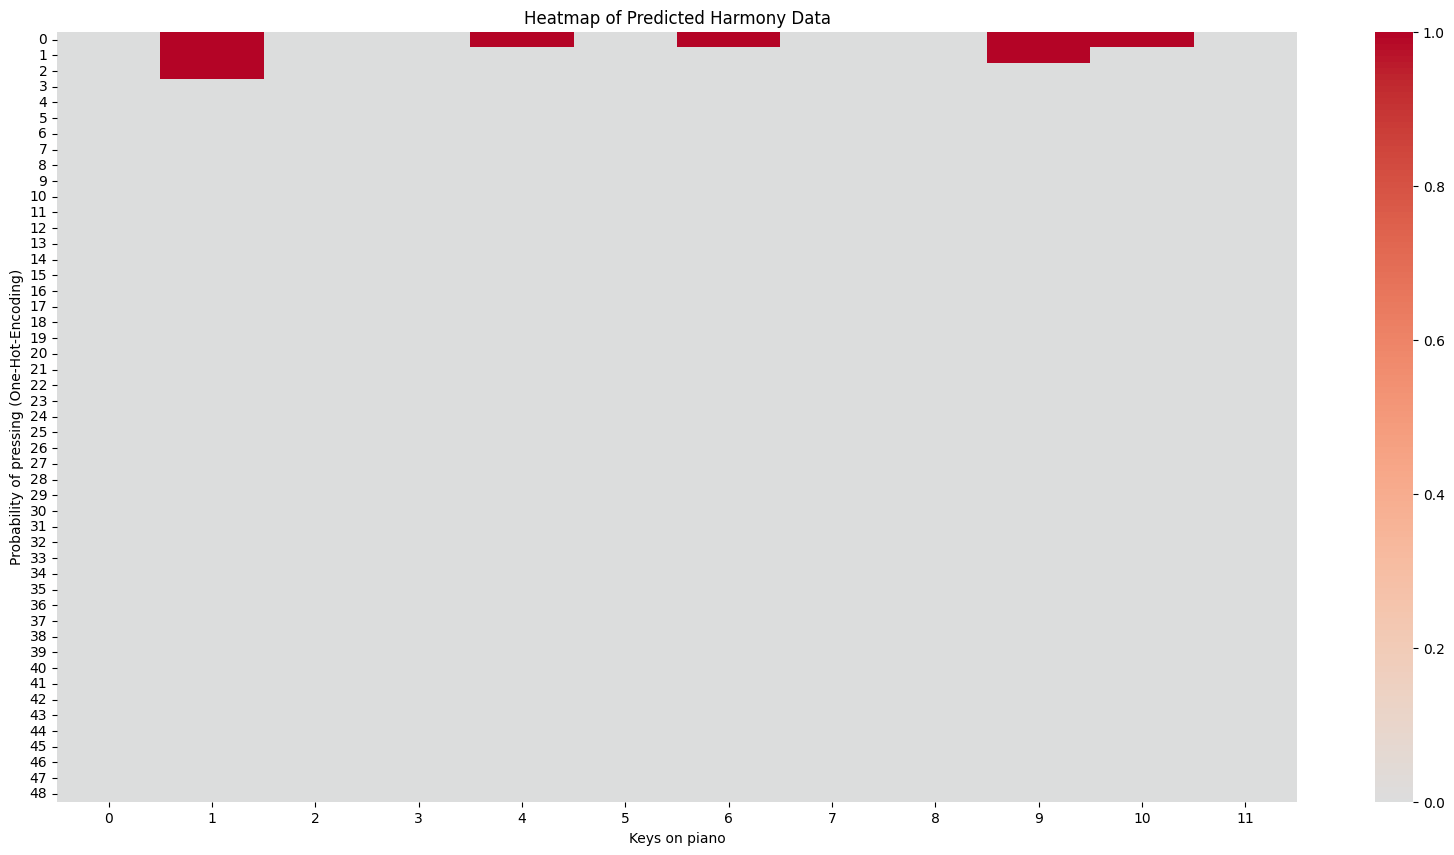

torch.Size([49, 12])
Output range: 0.0007924371748231351 0.1730809062719345
<class 'numpy.ndarray'>


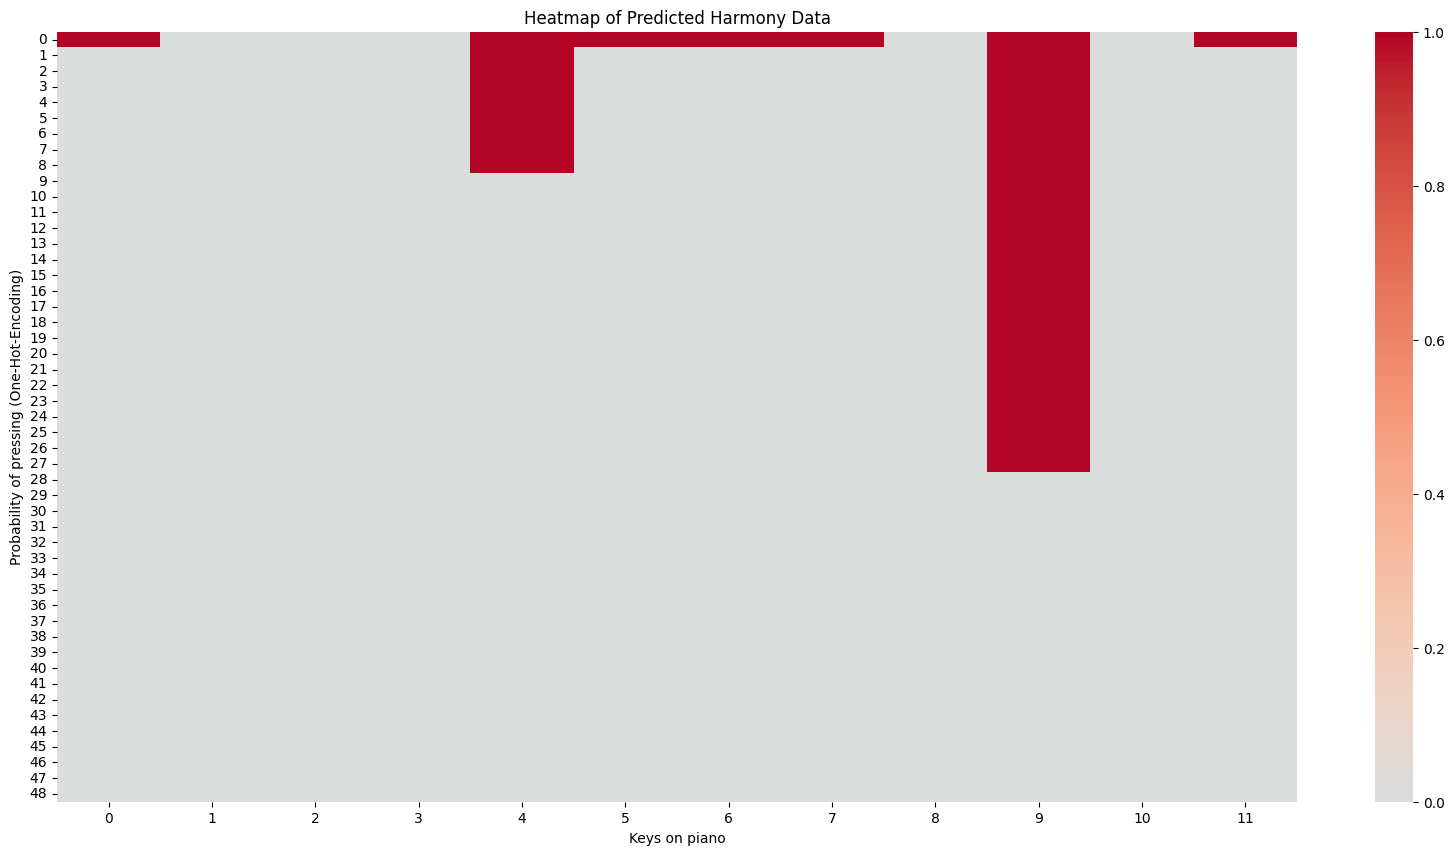

torch.Size([49, 12])
Output range: 0.00038135878276079893 0.17406310141086578
<class 'numpy.ndarray'>


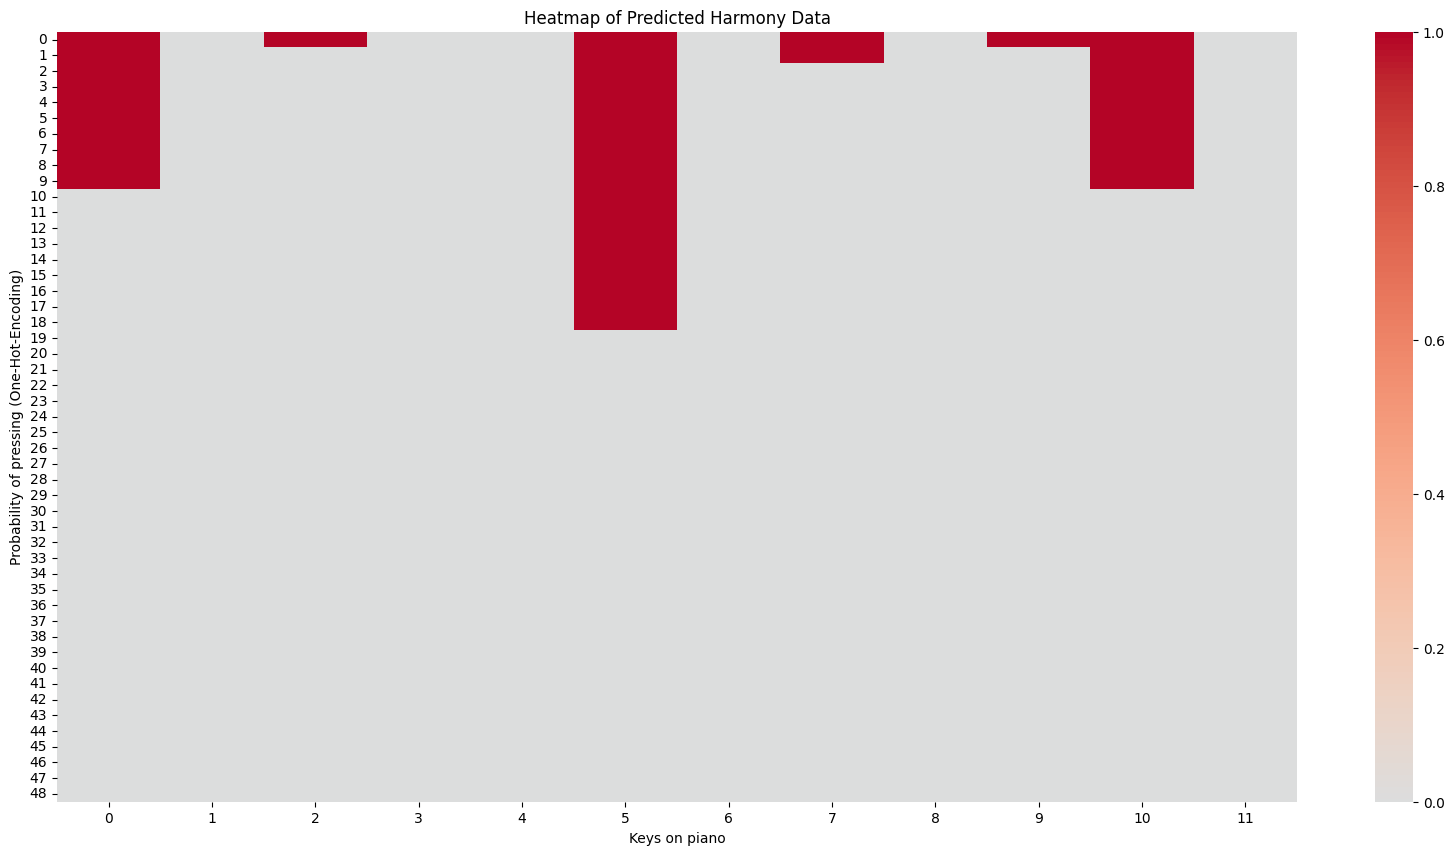

torch.Size([49, 12])
Output range: 0.0016455723671242595 0.1334953010082245
<class 'numpy.ndarray'>


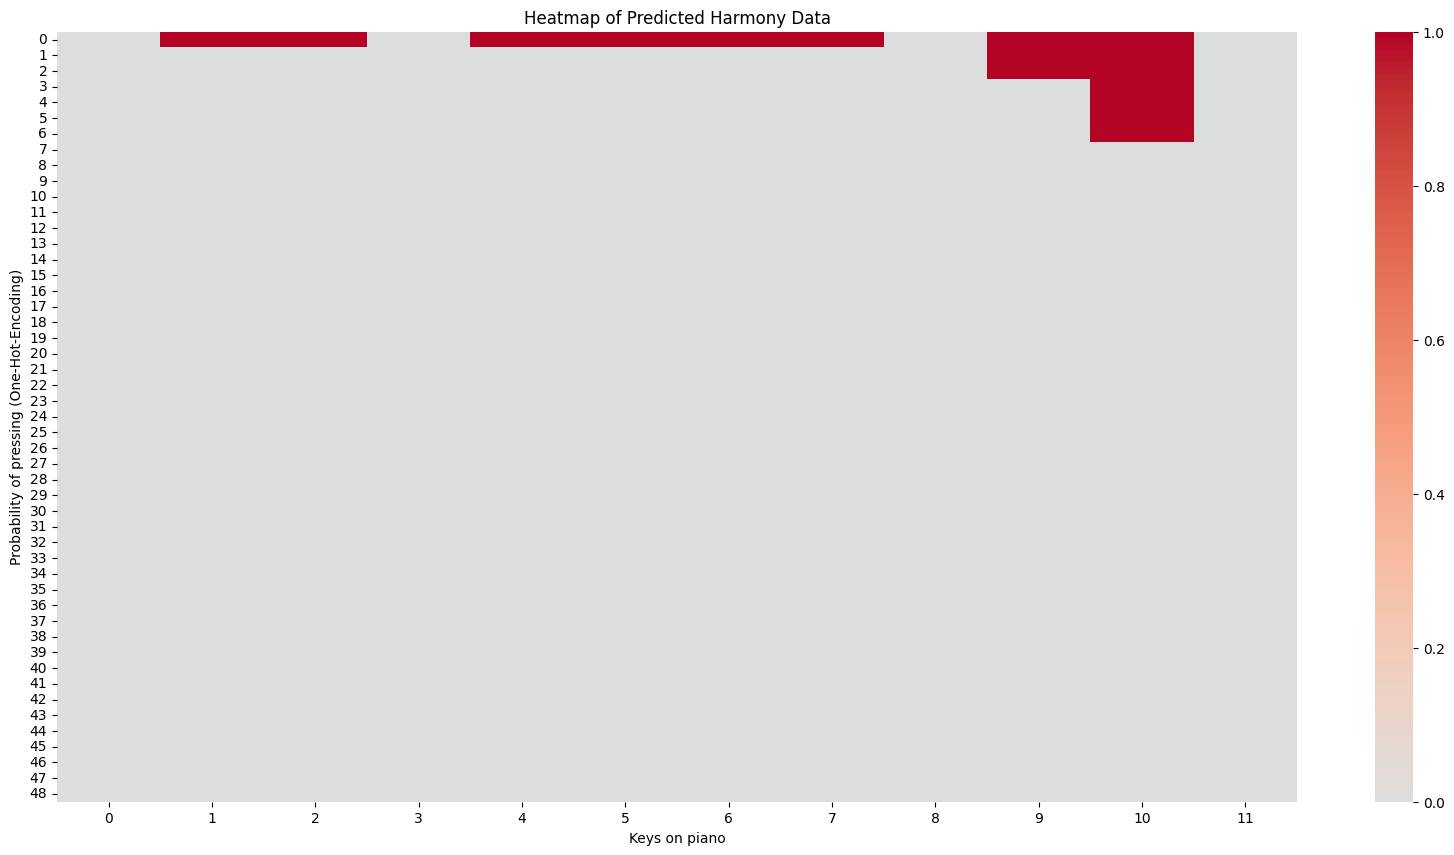

torch.Size([49, 12])
Output range: 0.0016441629268229008 0.10609720647335052
<class 'numpy.ndarray'>


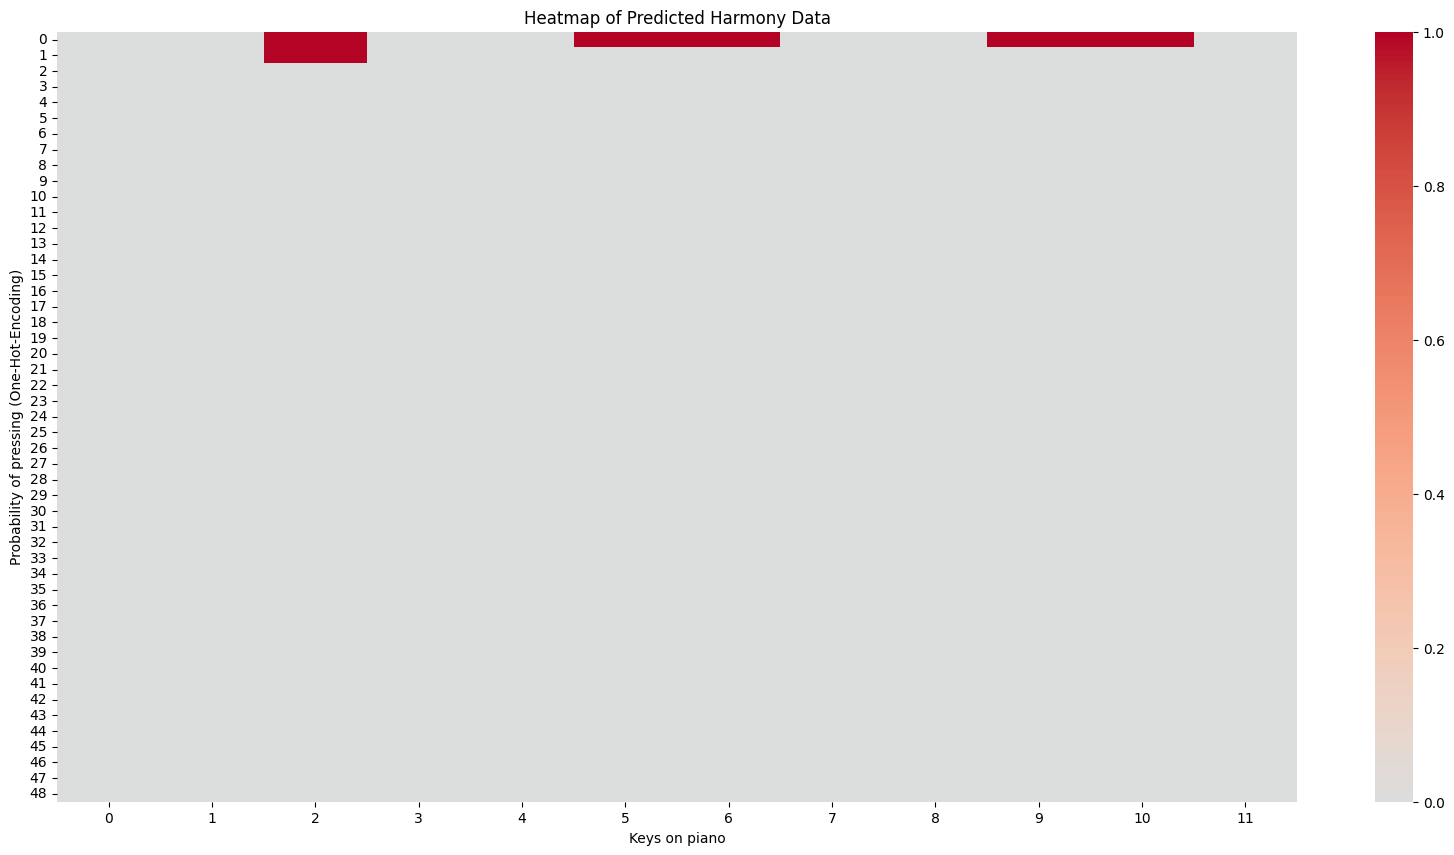

torch.Size([49, 12])
Output range: 0.0002136179100489244 0.1678188294172287
<class 'numpy.ndarray'>


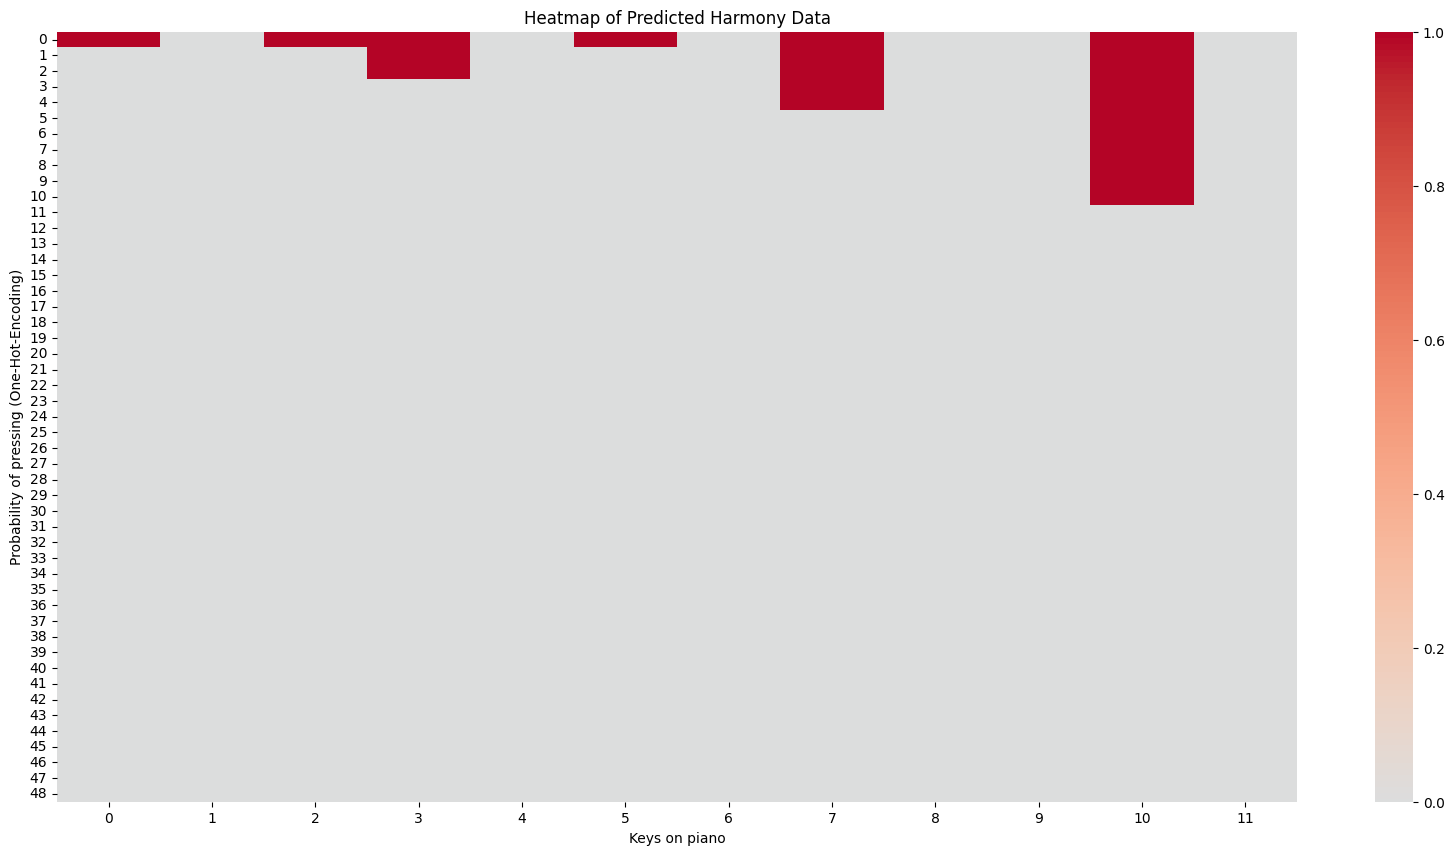

torch.Size([49, 12])
Output range: 0.00035939316148869693 0.2689906656742096
<class 'numpy.ndarray'>


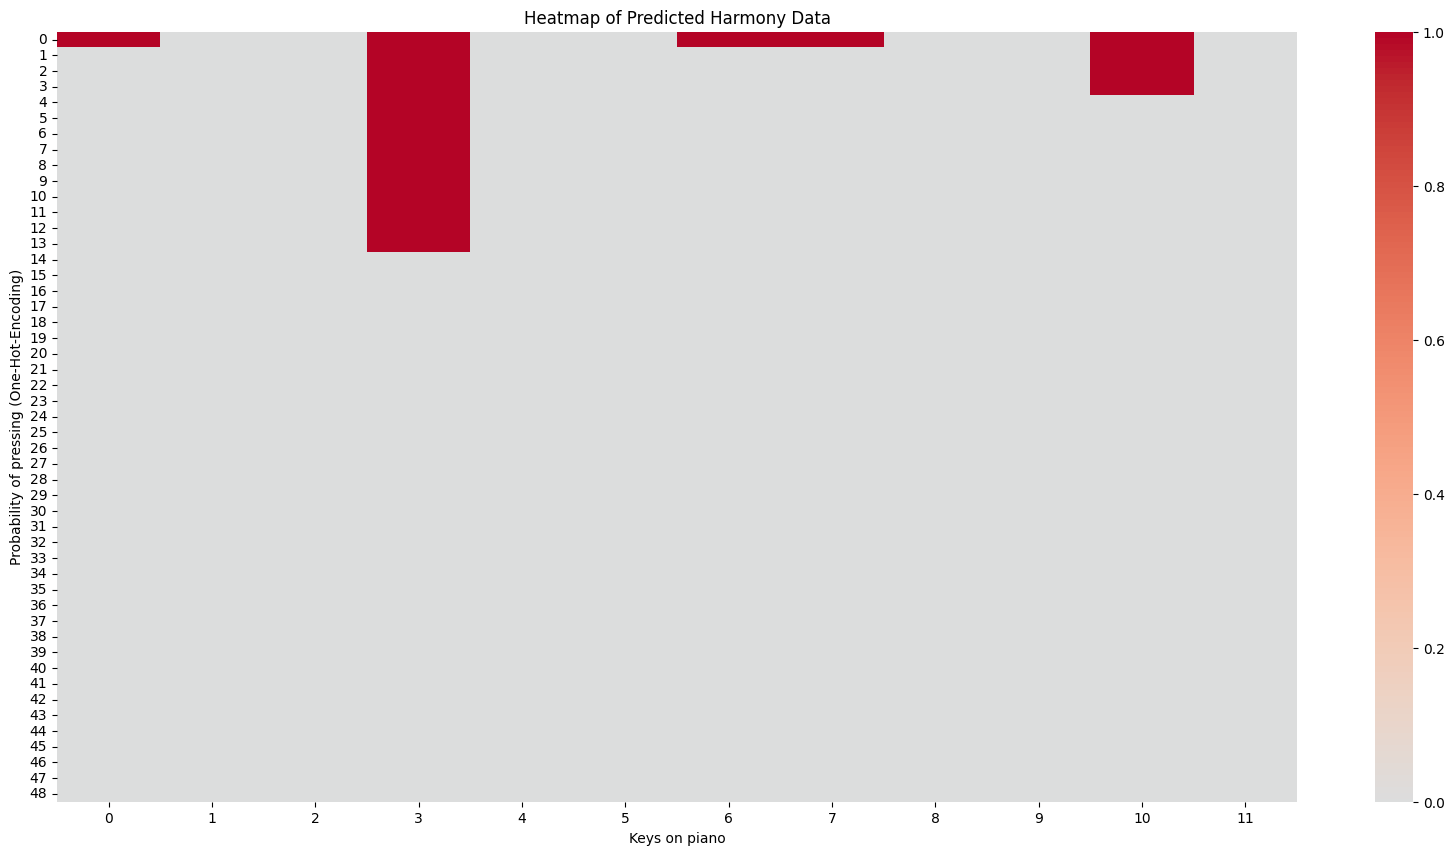

torch.Size([49, 12])
Output range: 0.0007239259430207312 0.11360359936952591
<class 'numpy.ndarray'>


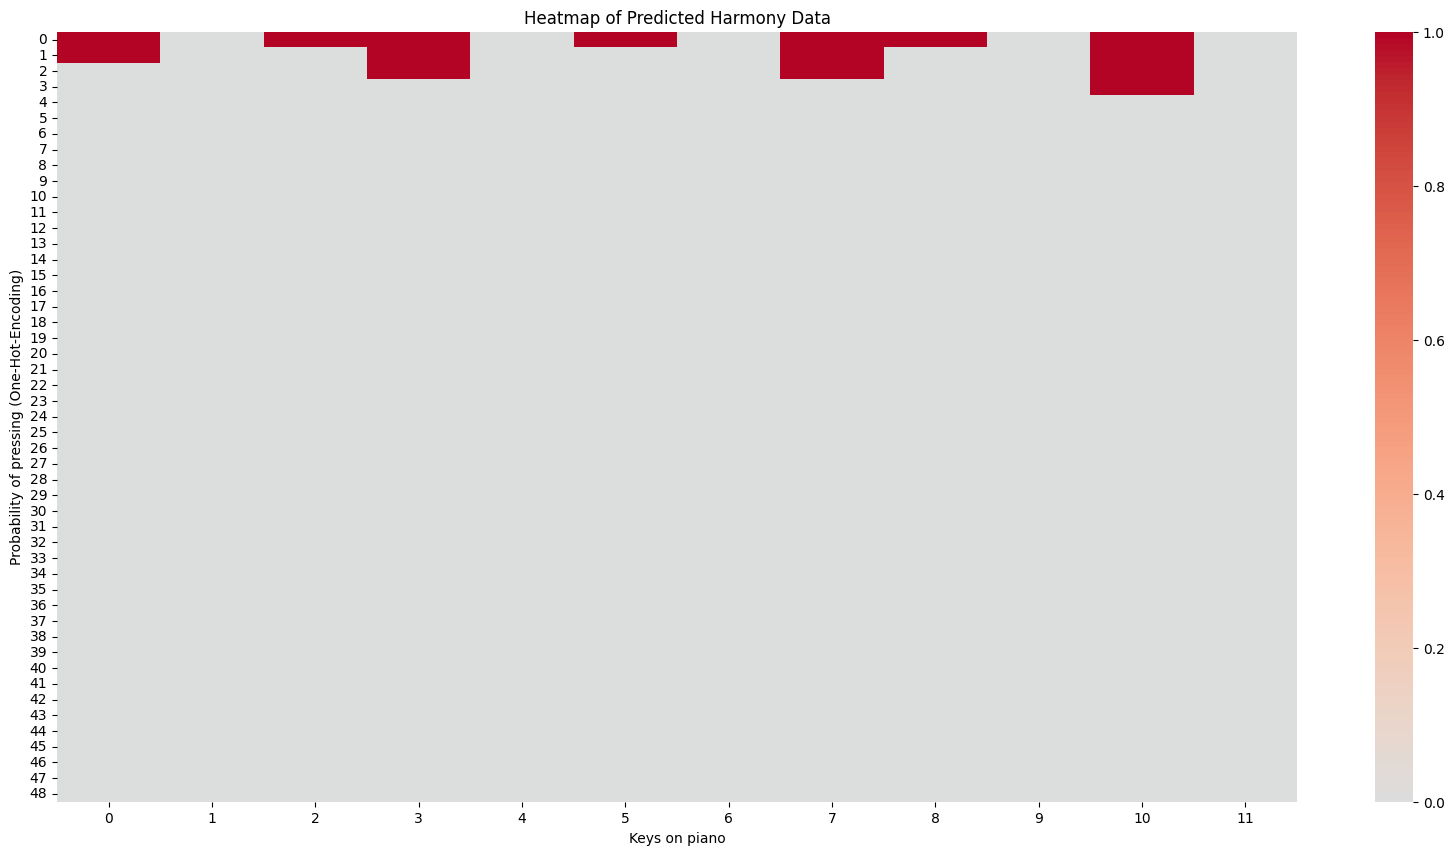

torch.Size([49, 12])
Output range: 0.0006141068879514933 0.13049186766147614
<class 'numpy.ndarray'>


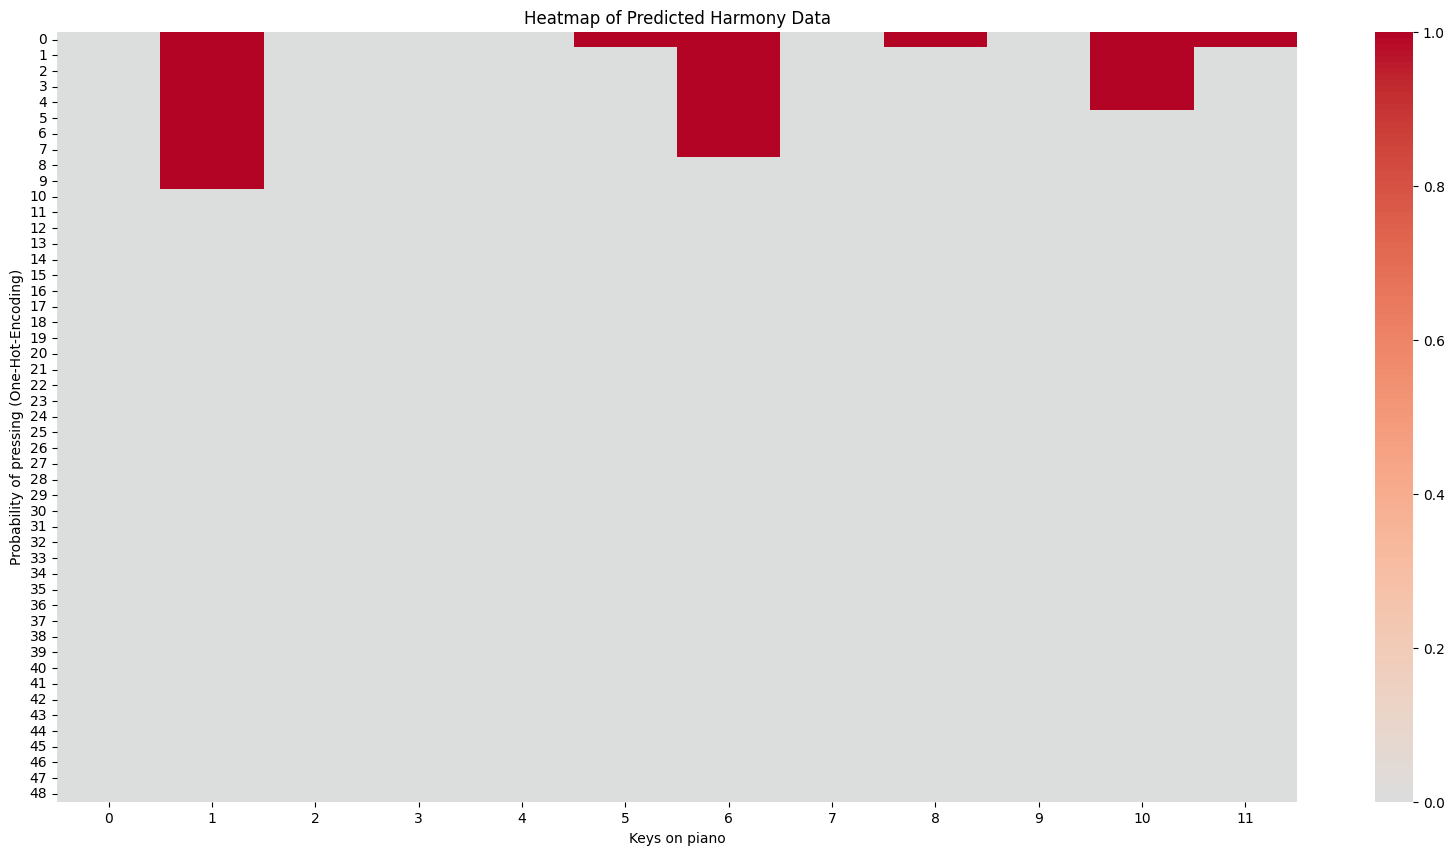

torch.Size([49, 12])
Output range: 0.0020124497823417187 0.0995611846446991
<class 'numpy.ndarray'>


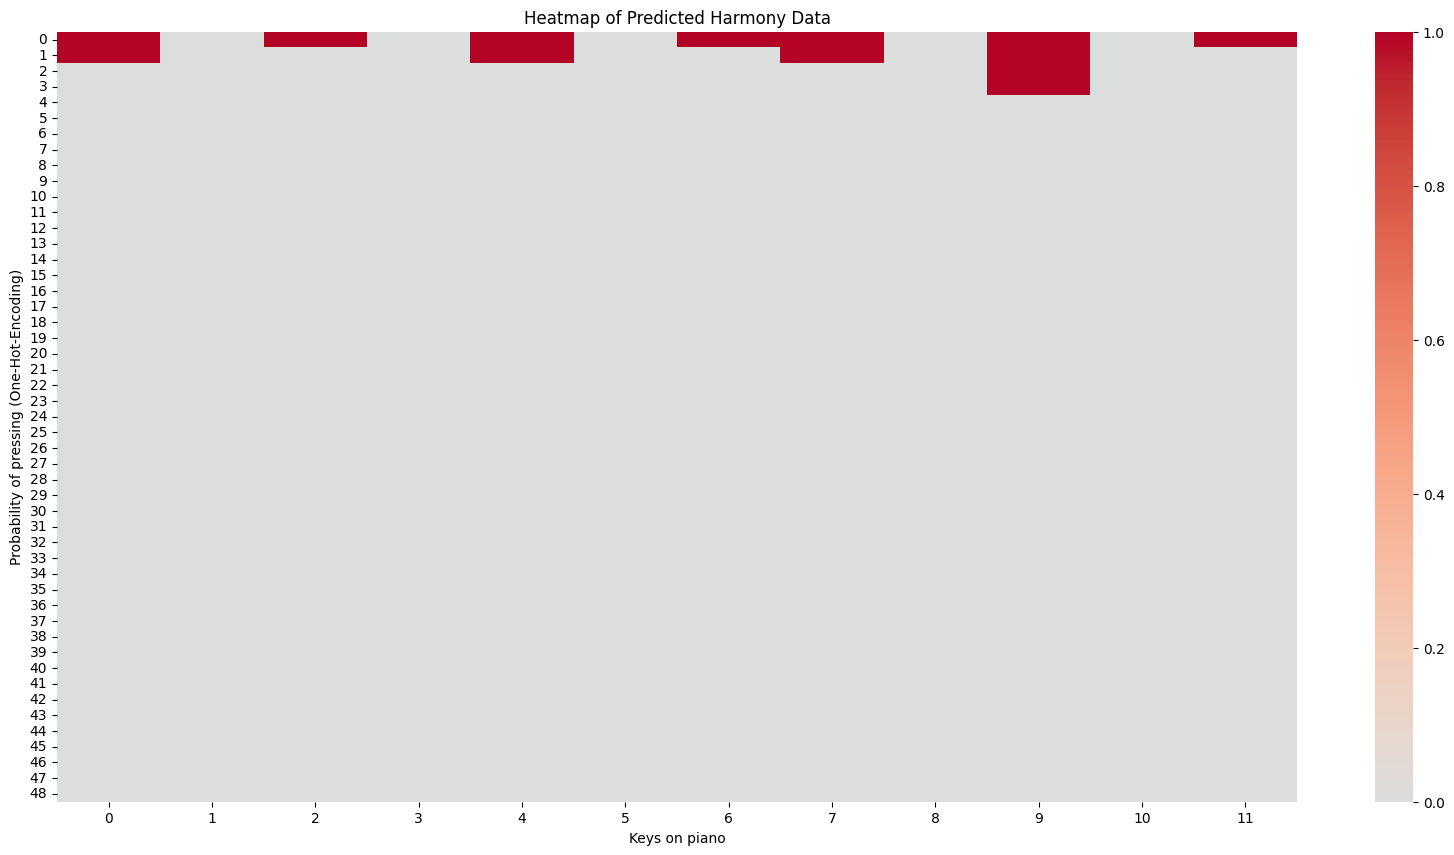

torch.Size([49, 12])
Output range: 0.001064404845237732 0.12860387563705444
<class 'numpy.ndarray'>


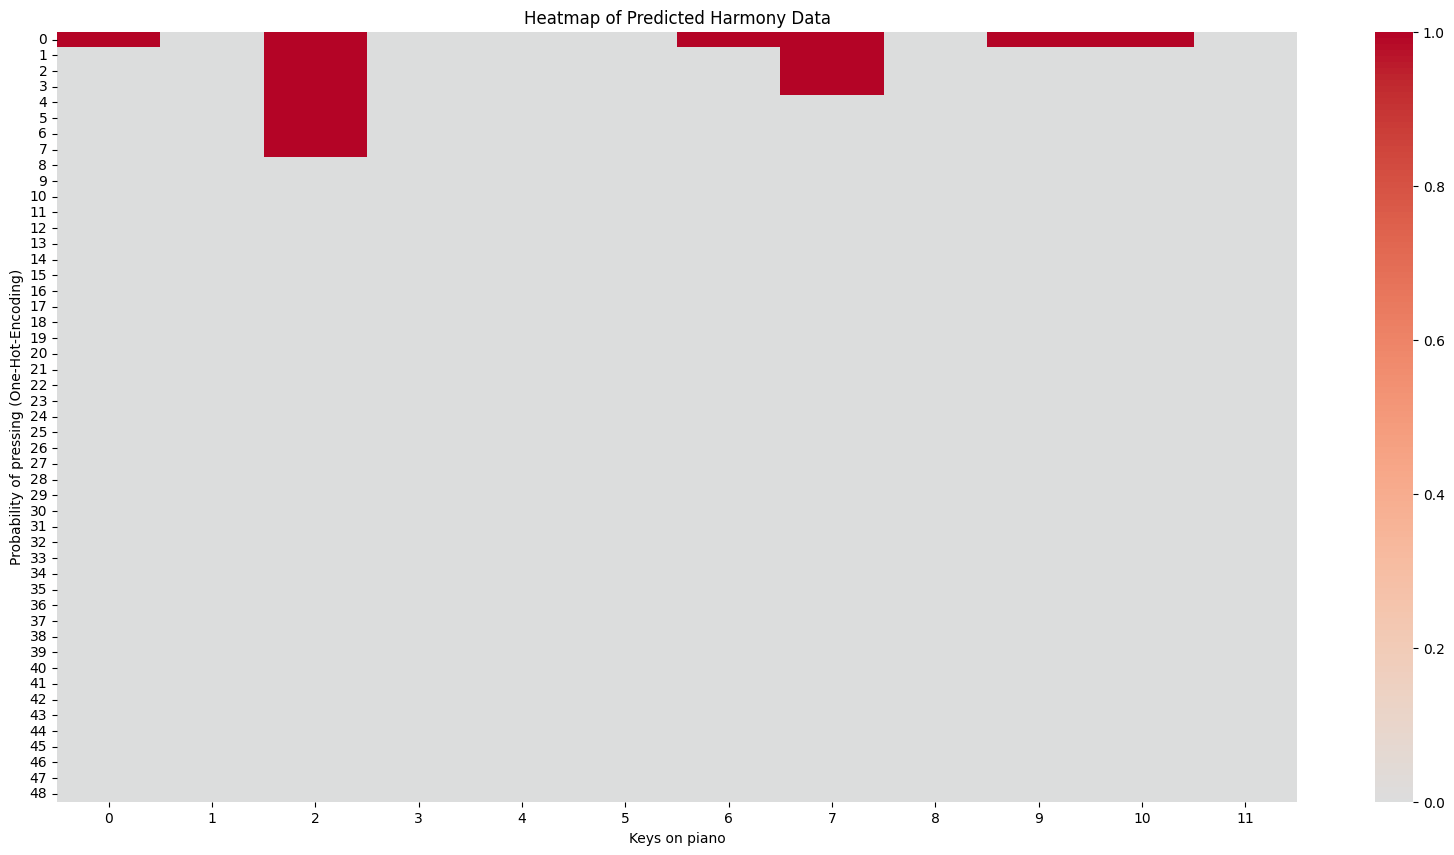

torch.Size([49, 12])
Output range: 0.0004572764737531543 0.14256511628627777
<class 'numpy.ndarray'>


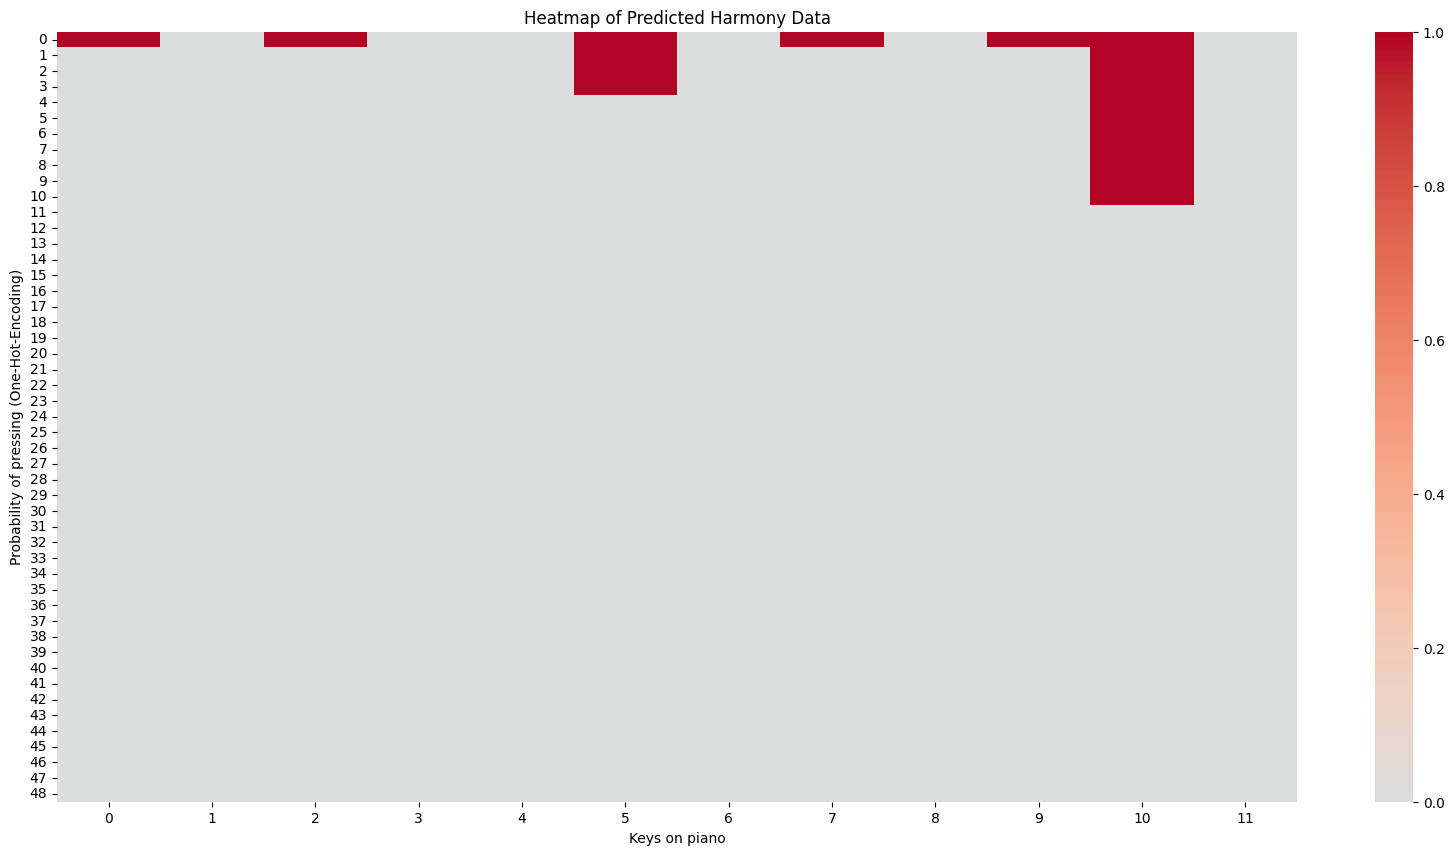

torch.Size([49, 12])
Output range: 0.00043606580584309995 0.11221866309642792
<class 'numpy.ndarray'>


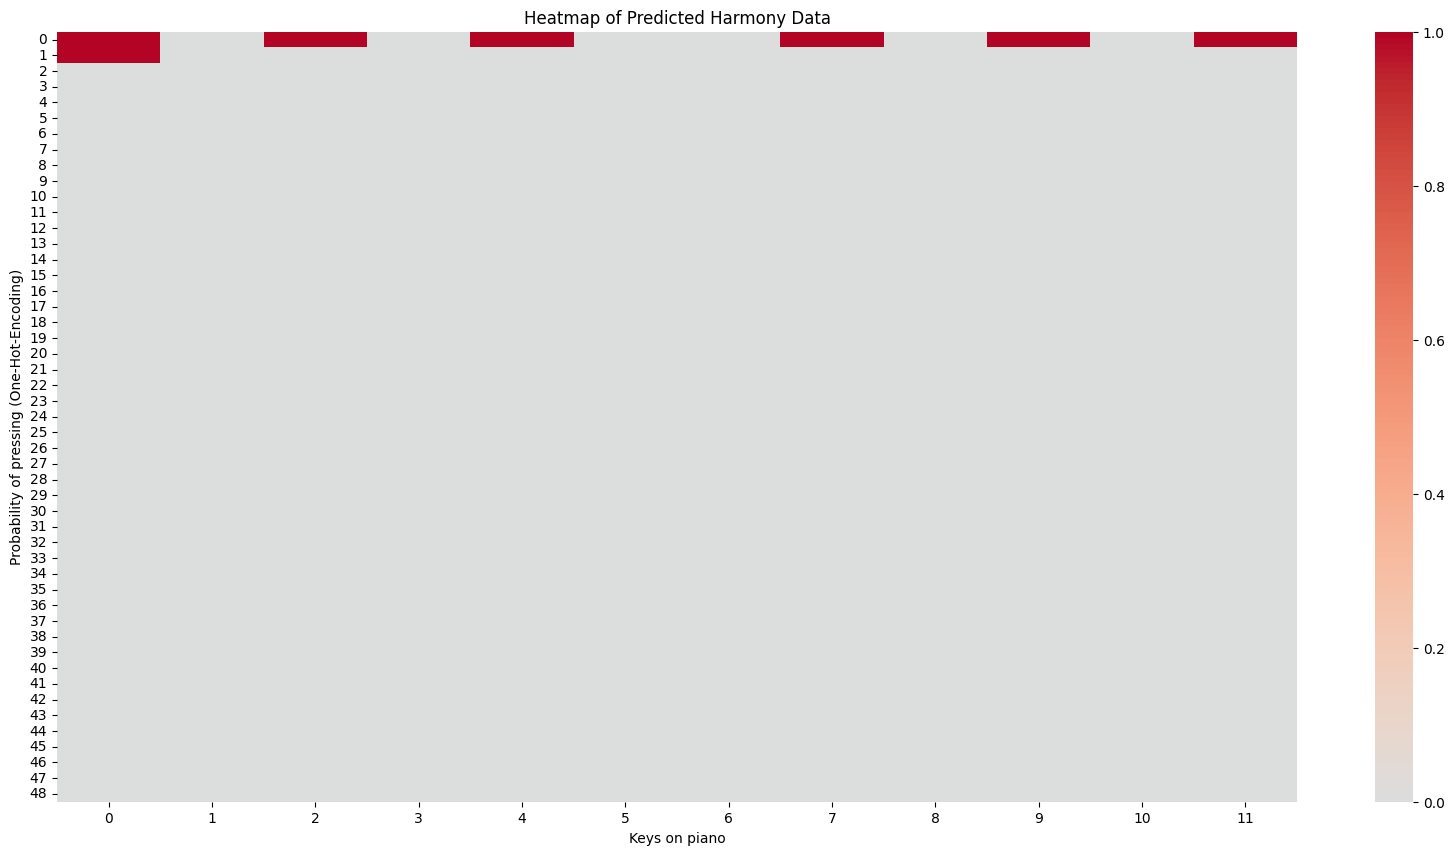

torch.Size([49, 12])
Output range: 0.0028890587855130434 0.0951363742351532
<class 'numpy.ndarray'>


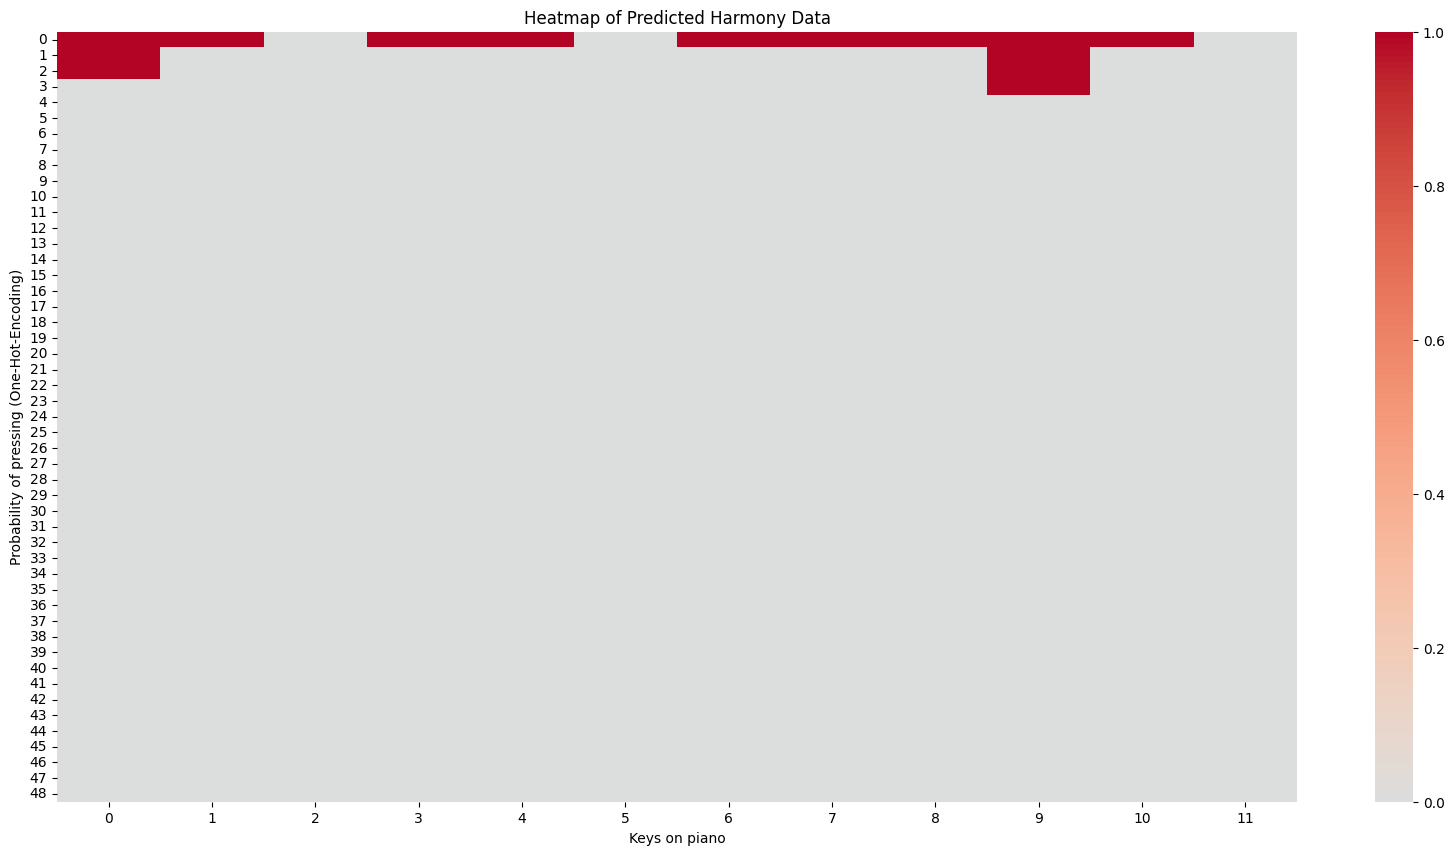

torch.Size([49, 12])
Output range: 0.0018443168373778462 0.11507833003997803
<class 'numpy.ndarray'>


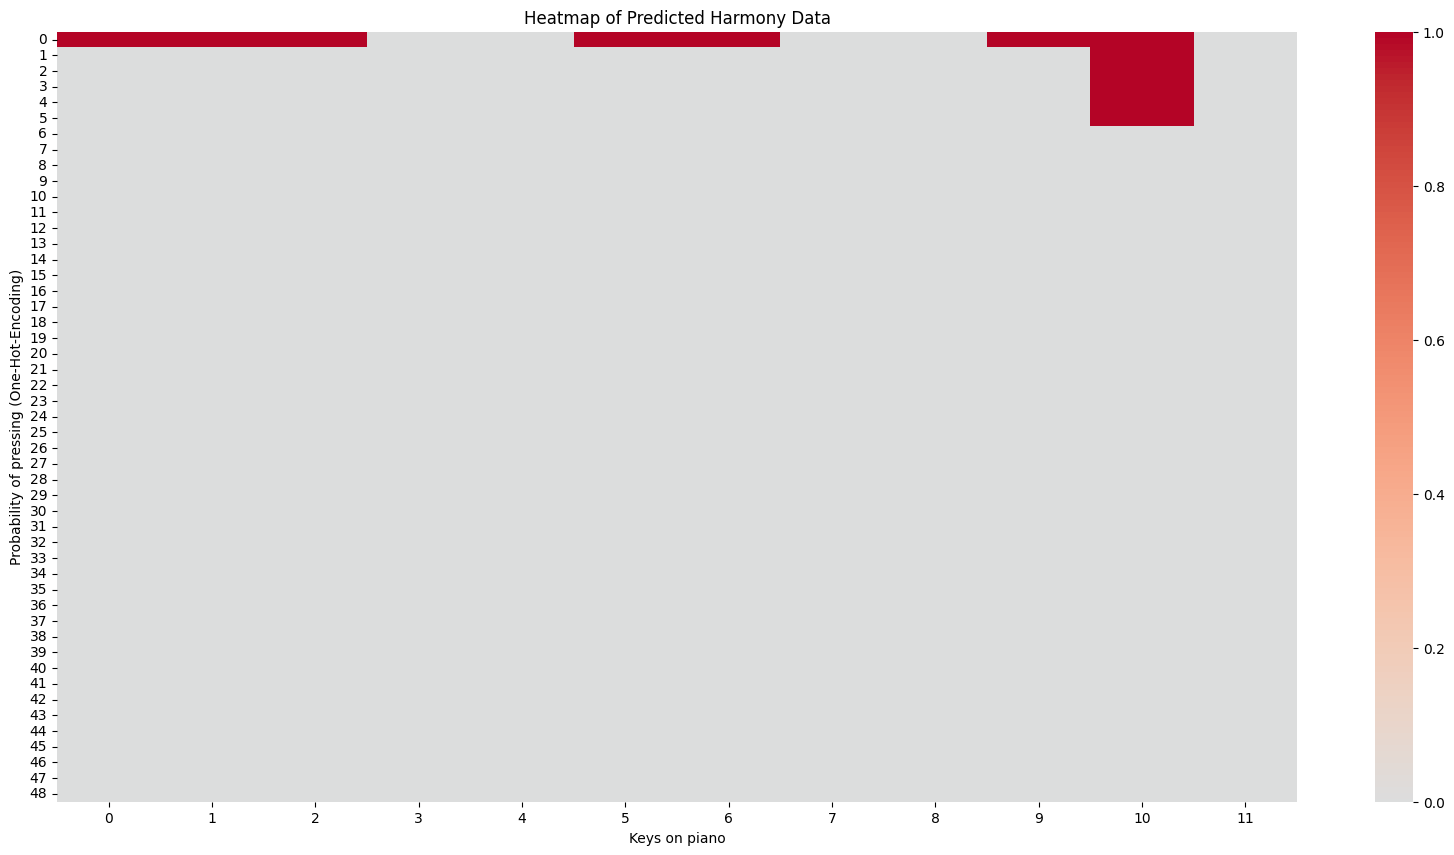

torch.Size([49, 12])
Output range: 0.0003358676331117749 0.1478041261434555
<class 'numpy.ndarray'>


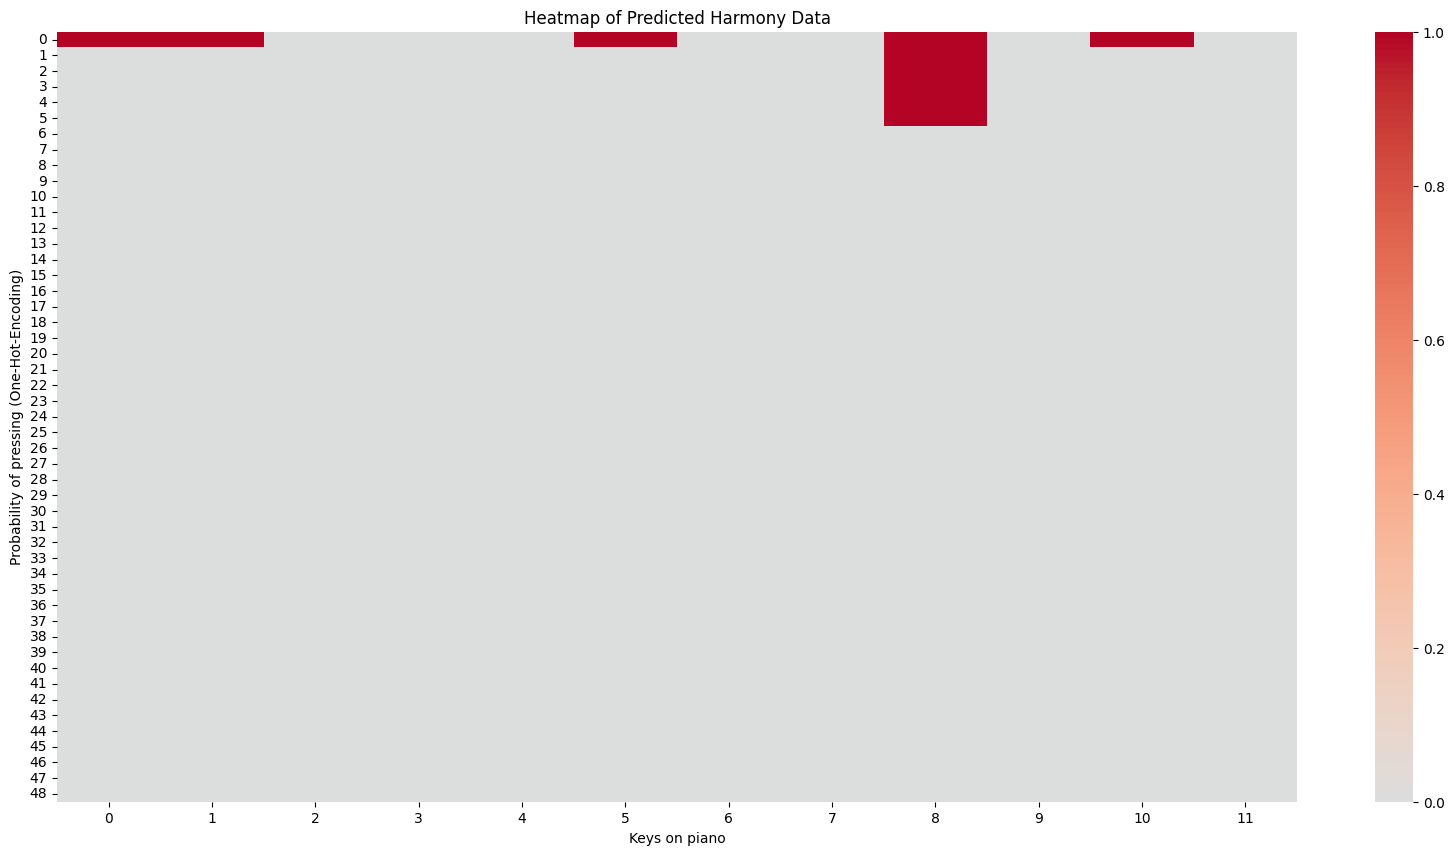

torch.Size([49, 12])
Output range: 0.00040716712828725576 0.12214691191911697
<class 'numpy.ndarray'>


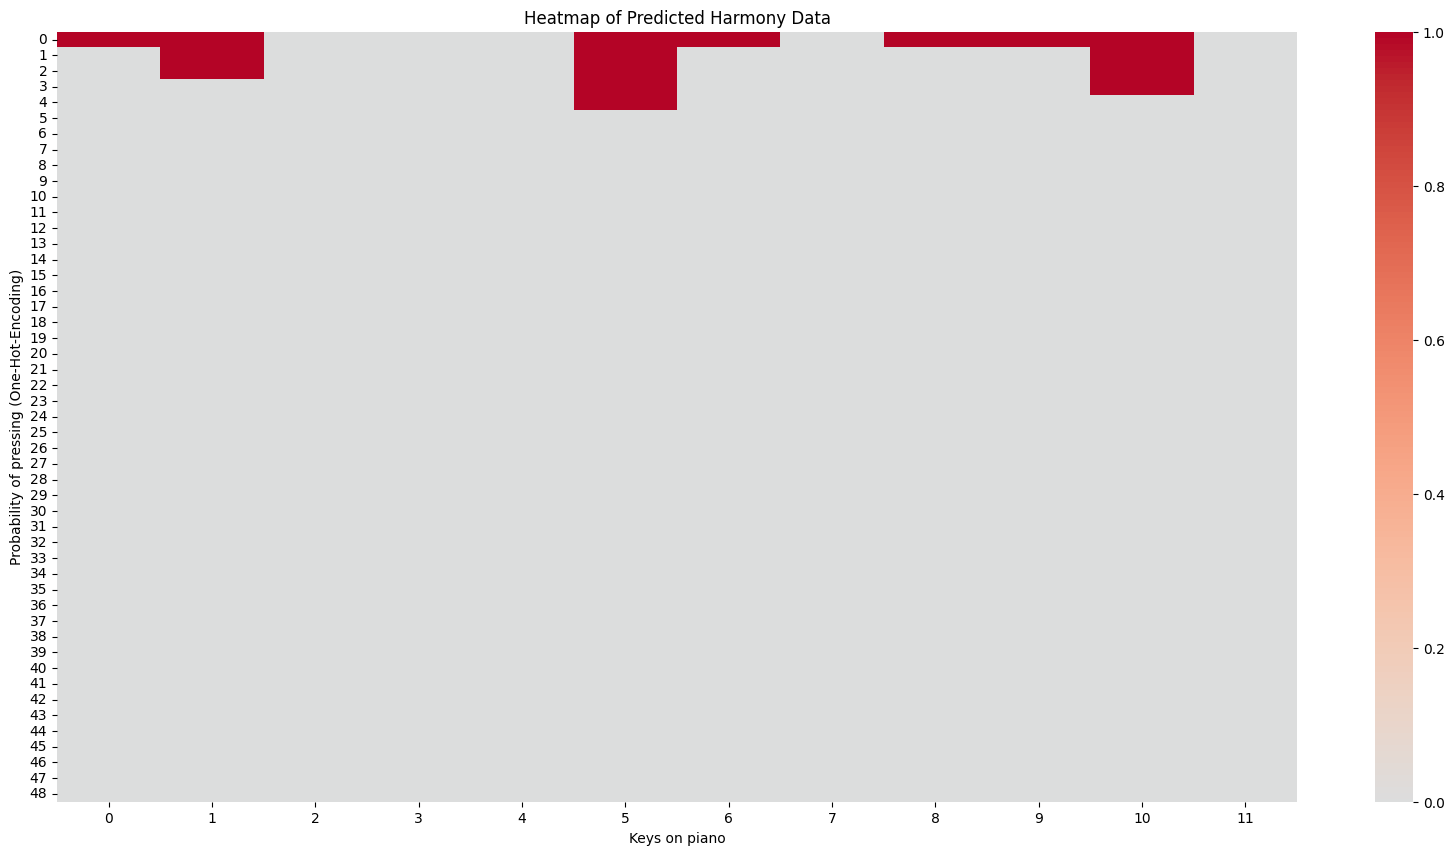

torch.Size([49, 12])
Output range: 0.00017036501958500594 0.24188777804374695
<class 'numpy.ndarray'>


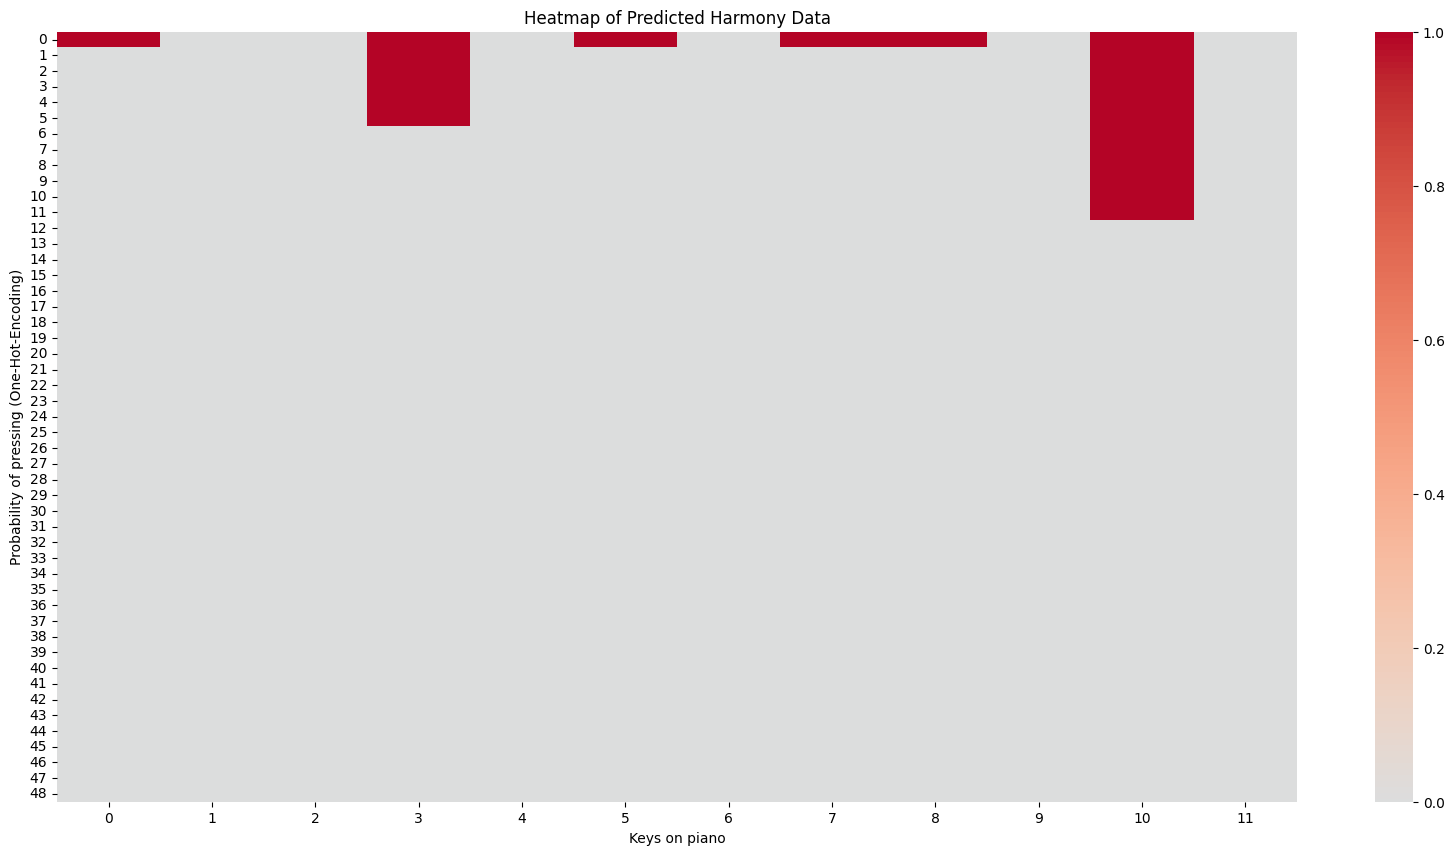

torch.Size([49, 12])
Output range: 0.002676582895219326 0.08048935979604721
<class 'numpy.ndarray'>


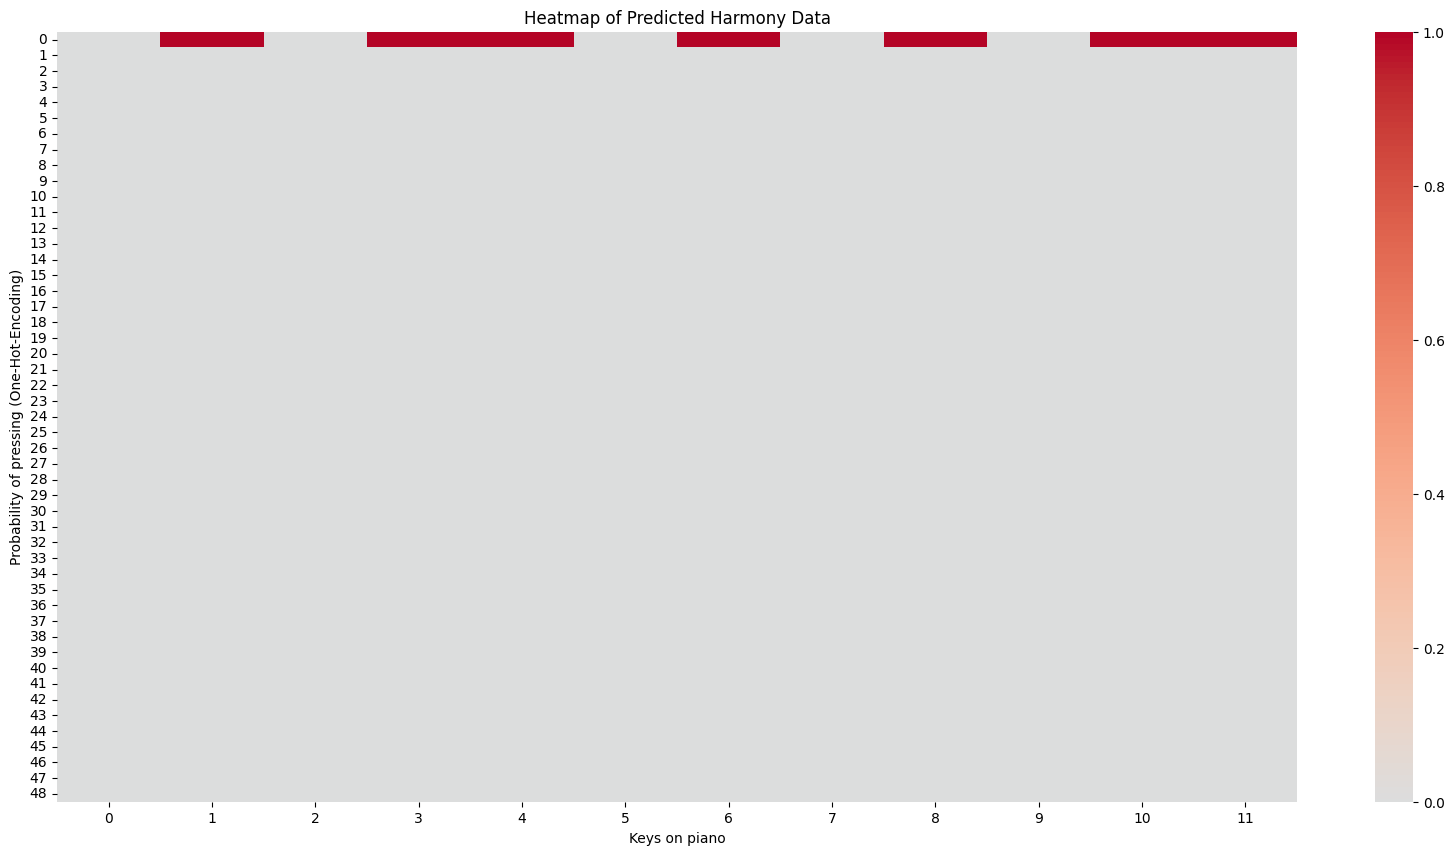

torch.Size([49, 12])
Output range: 0.0027151829563081264 0.10867460072040558
<class 'numpy.ndarray'>


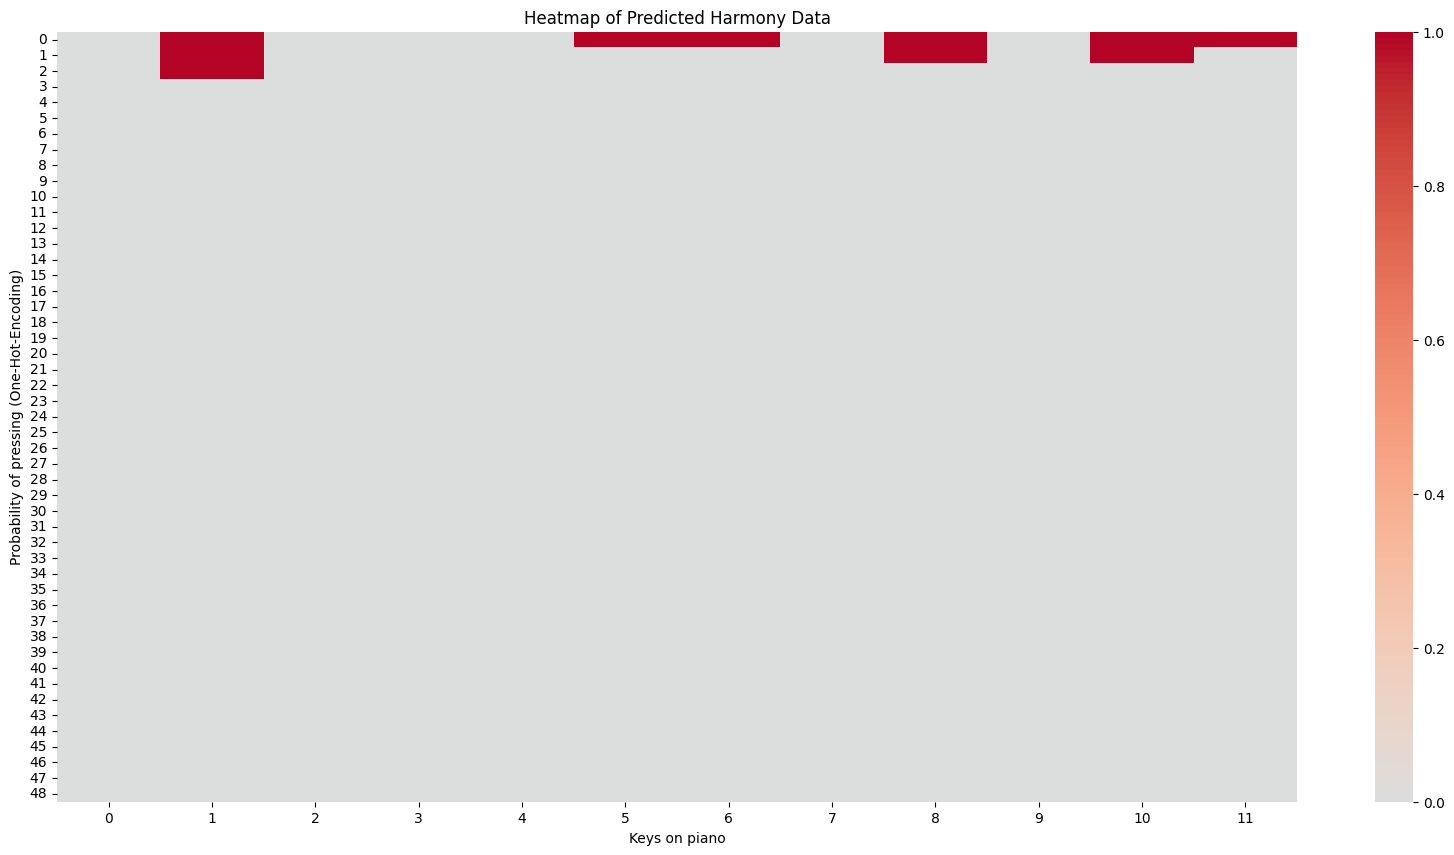

torch.Size([49, 12])
Output range: 0.0017745888326317072 0.09747570753097534
<class 'numpy.ndarray'>


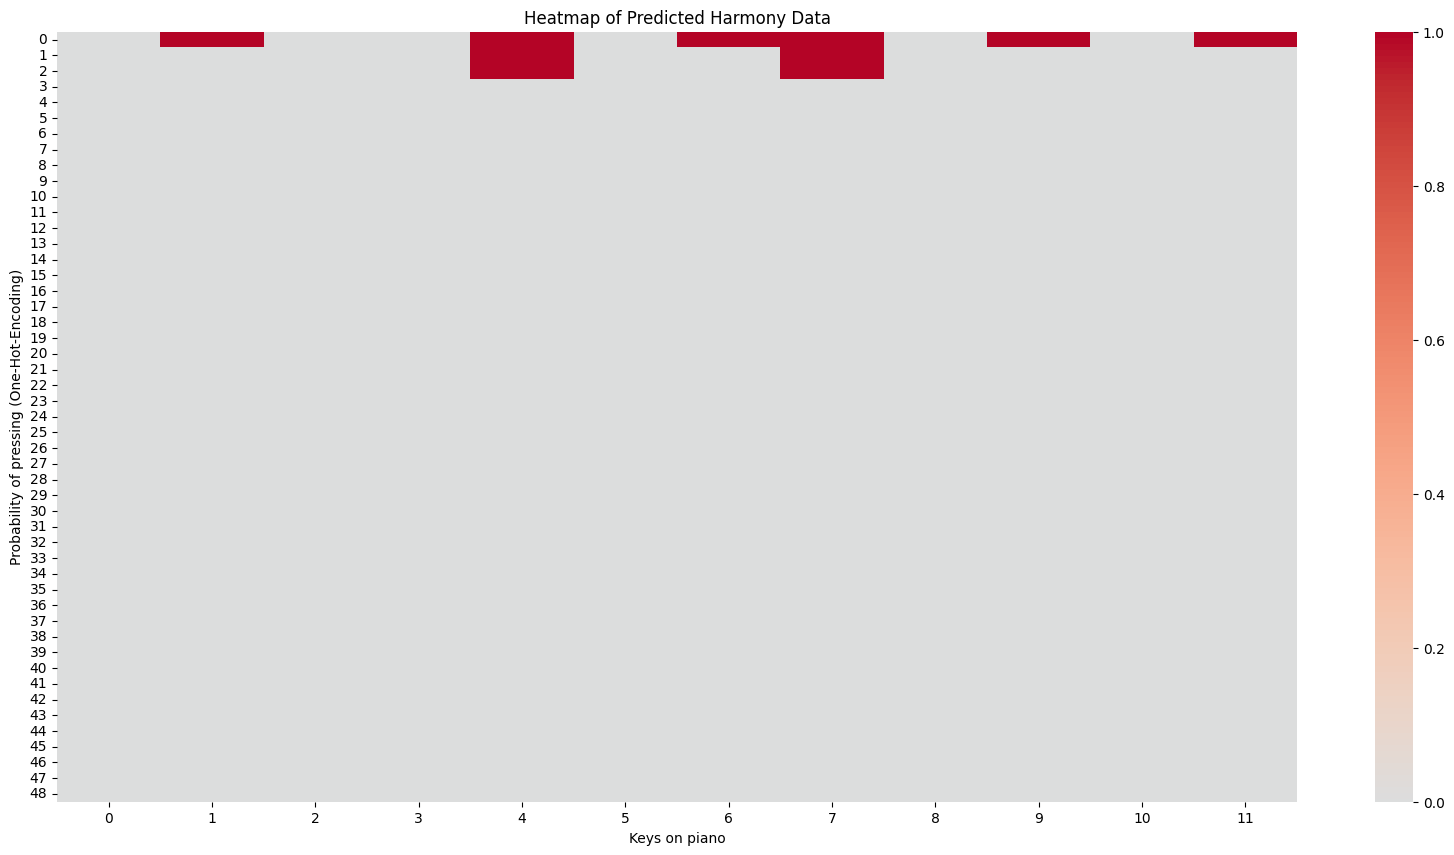

torch.Size([49, 12])
Output range: 0.0003674299514386803 0.13963986933231354
<class 'numpy.ndarray'>


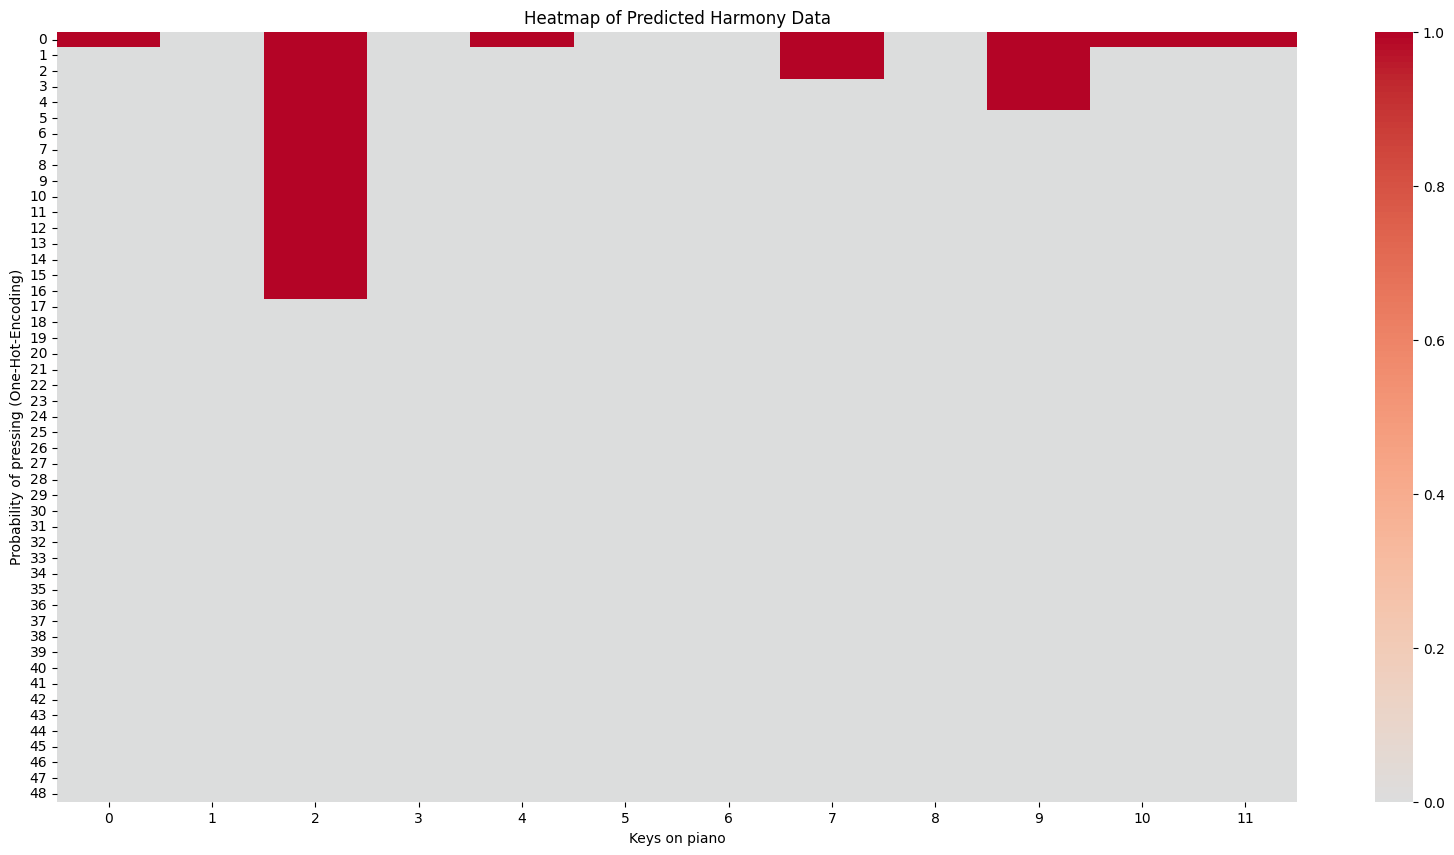

torch.Size([49, 12])
Output range: 0.0002331178548047319 0.1022581234574318
<class 'numpy.ndarray'>


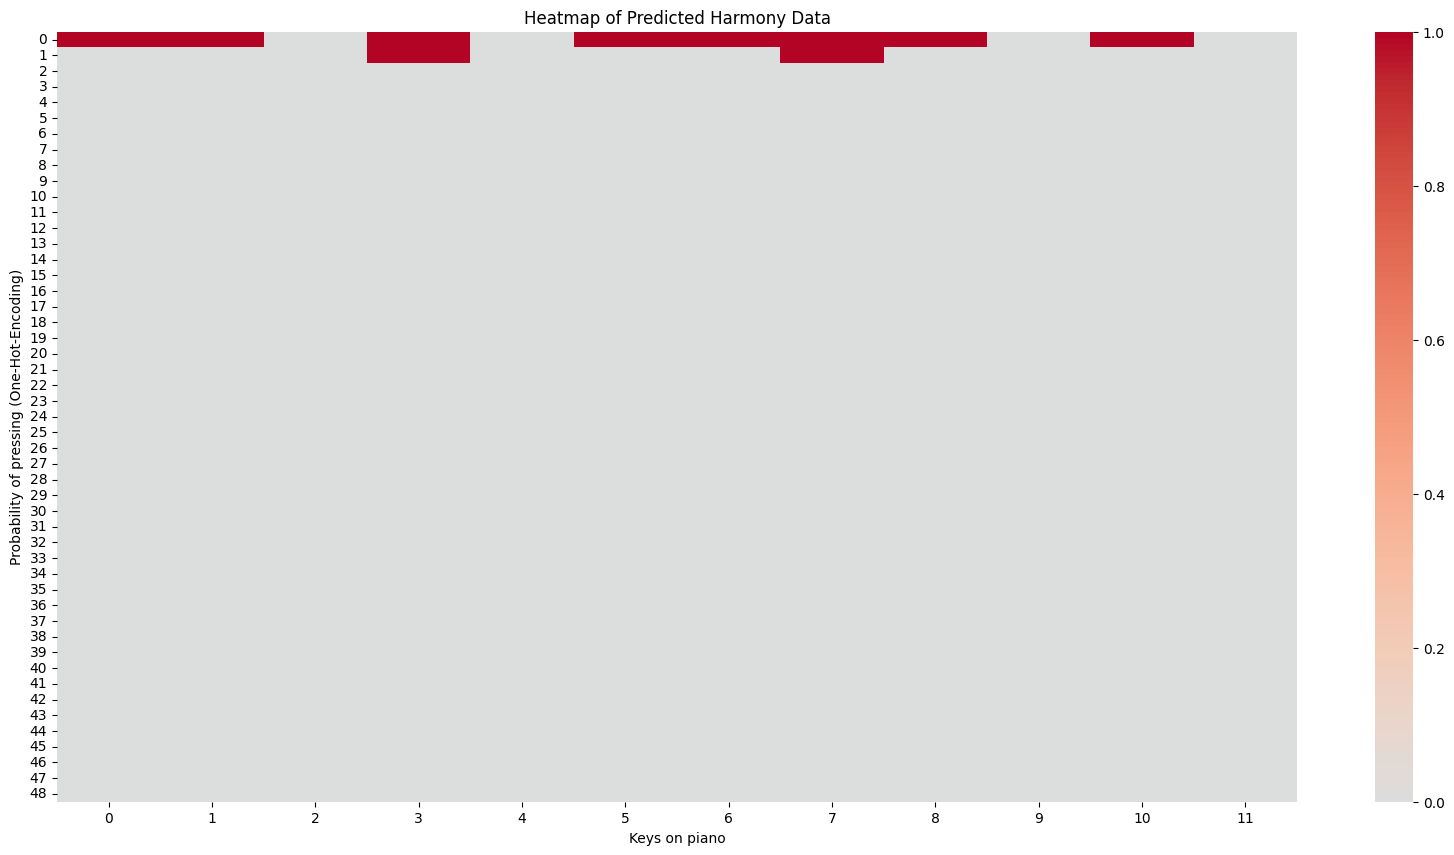

torch.Size([49, 12])
Output range: 0.0011975436937063932 0.12540185451507568
<class 'numpy.ndarray'>


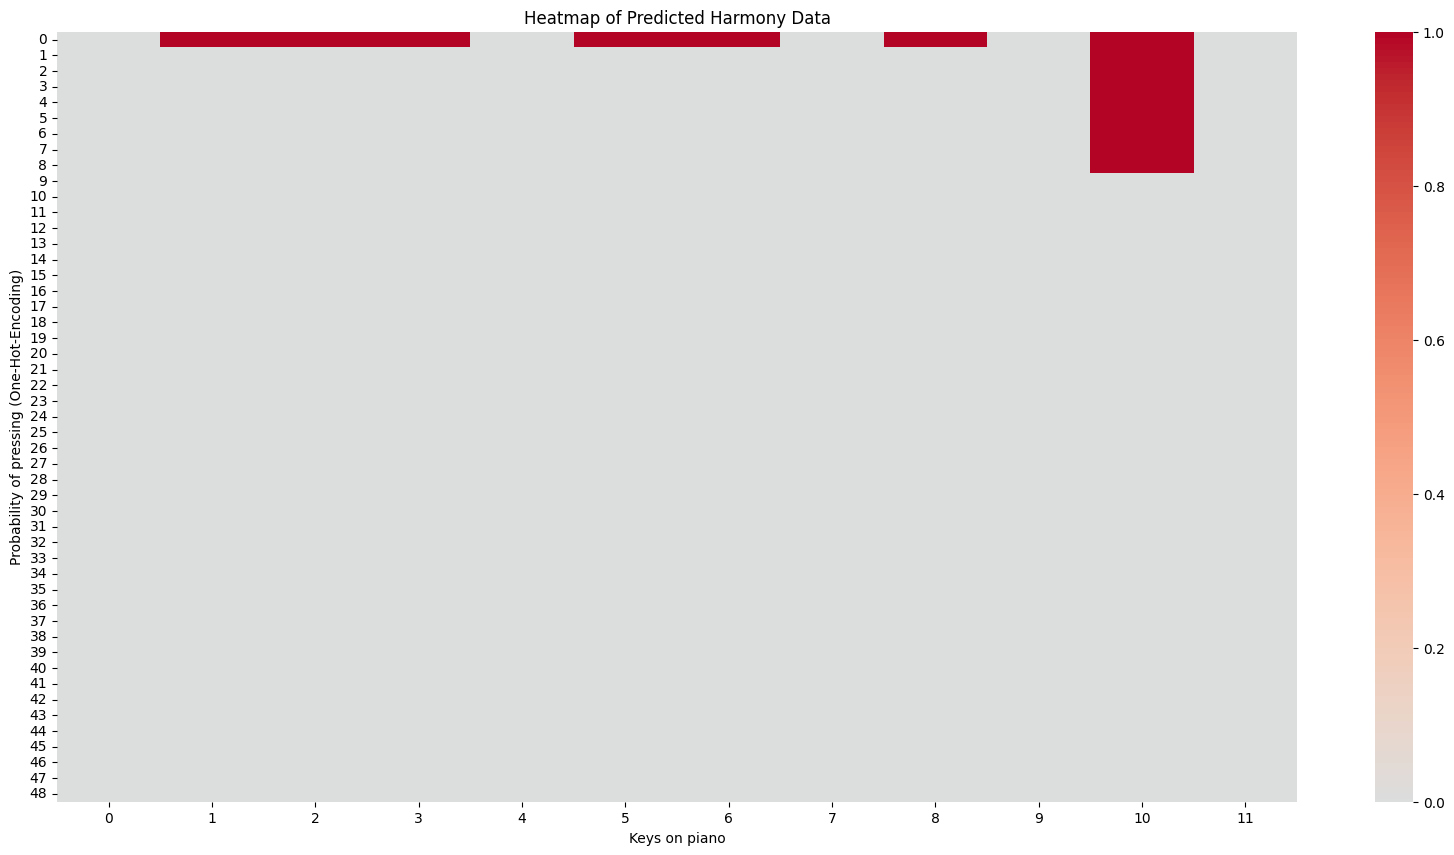

torch.Size([49, 12])
Output range: 0.0002636100398376584 0.25123676657676697
<class 'numpy.ndarray'>


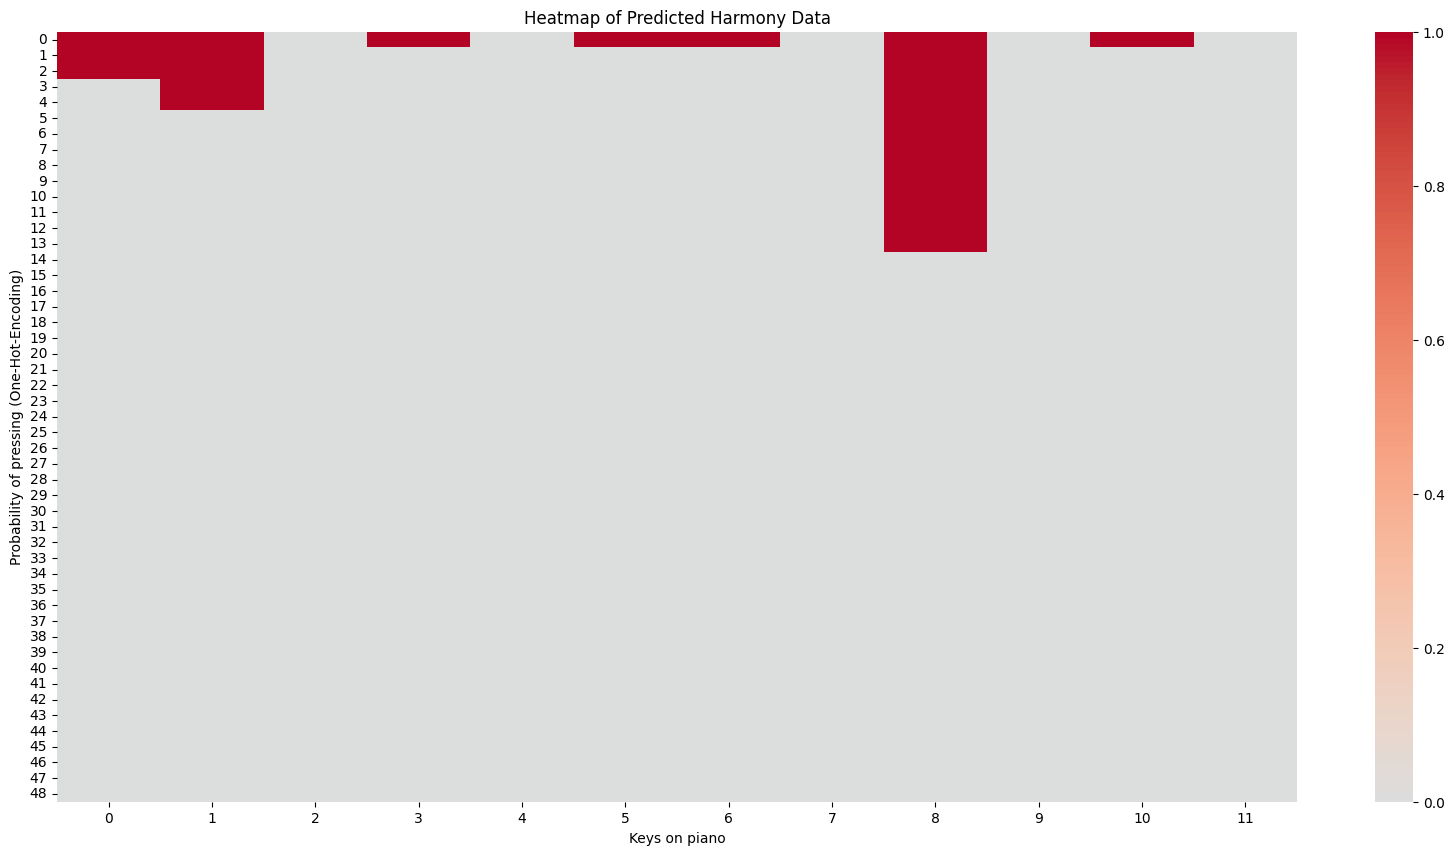

torch.Size([49, 12])
Output range: 0.0006584720686078072 0.12303133308887482
<class 'numpy.ndarray'>


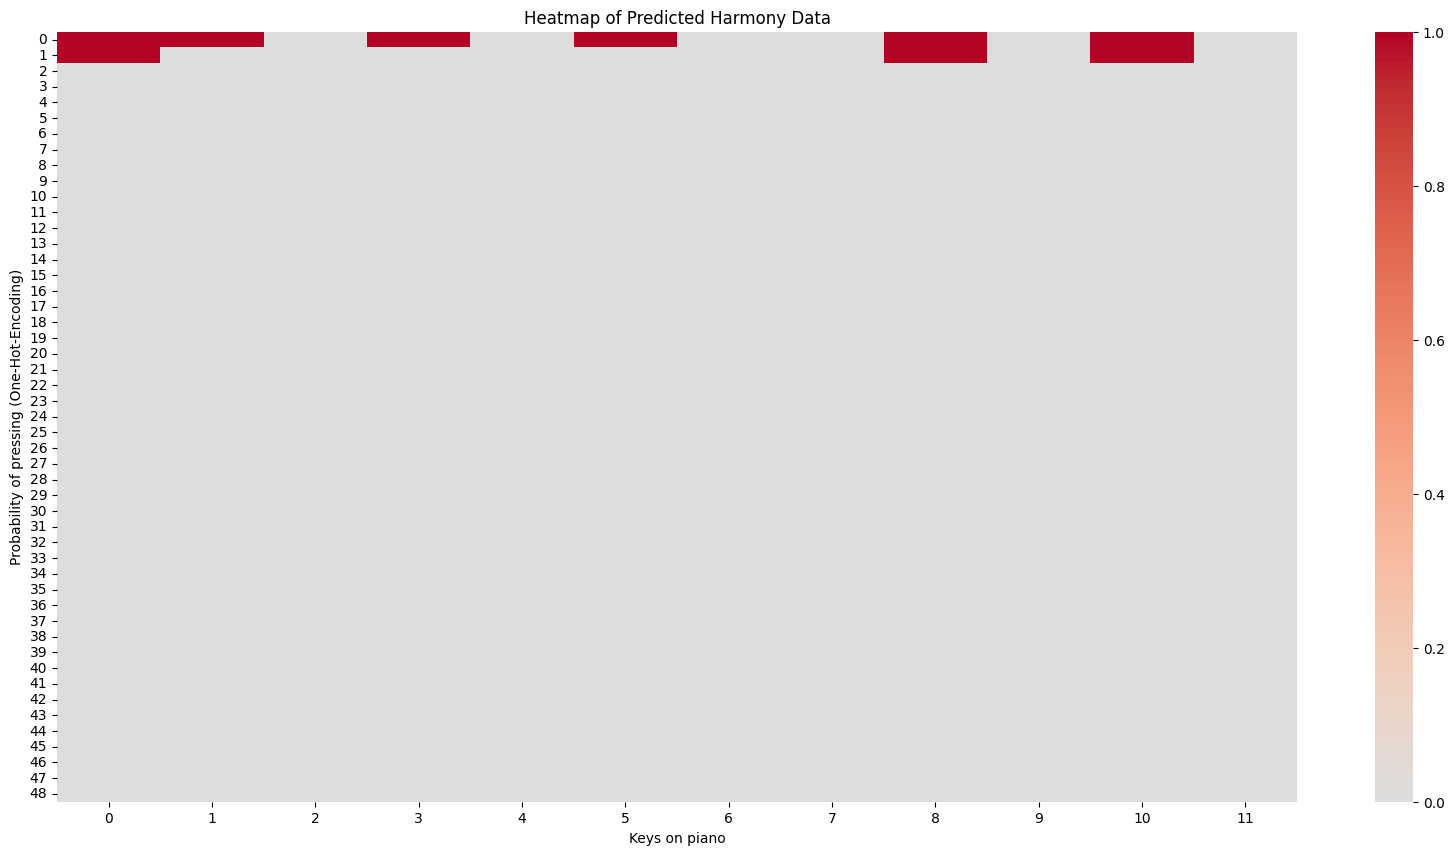

torch.Size([49, 12])
Output range: 0.0010998023208230734 0.10717485100030899
<class 'numpy.ndarray'>


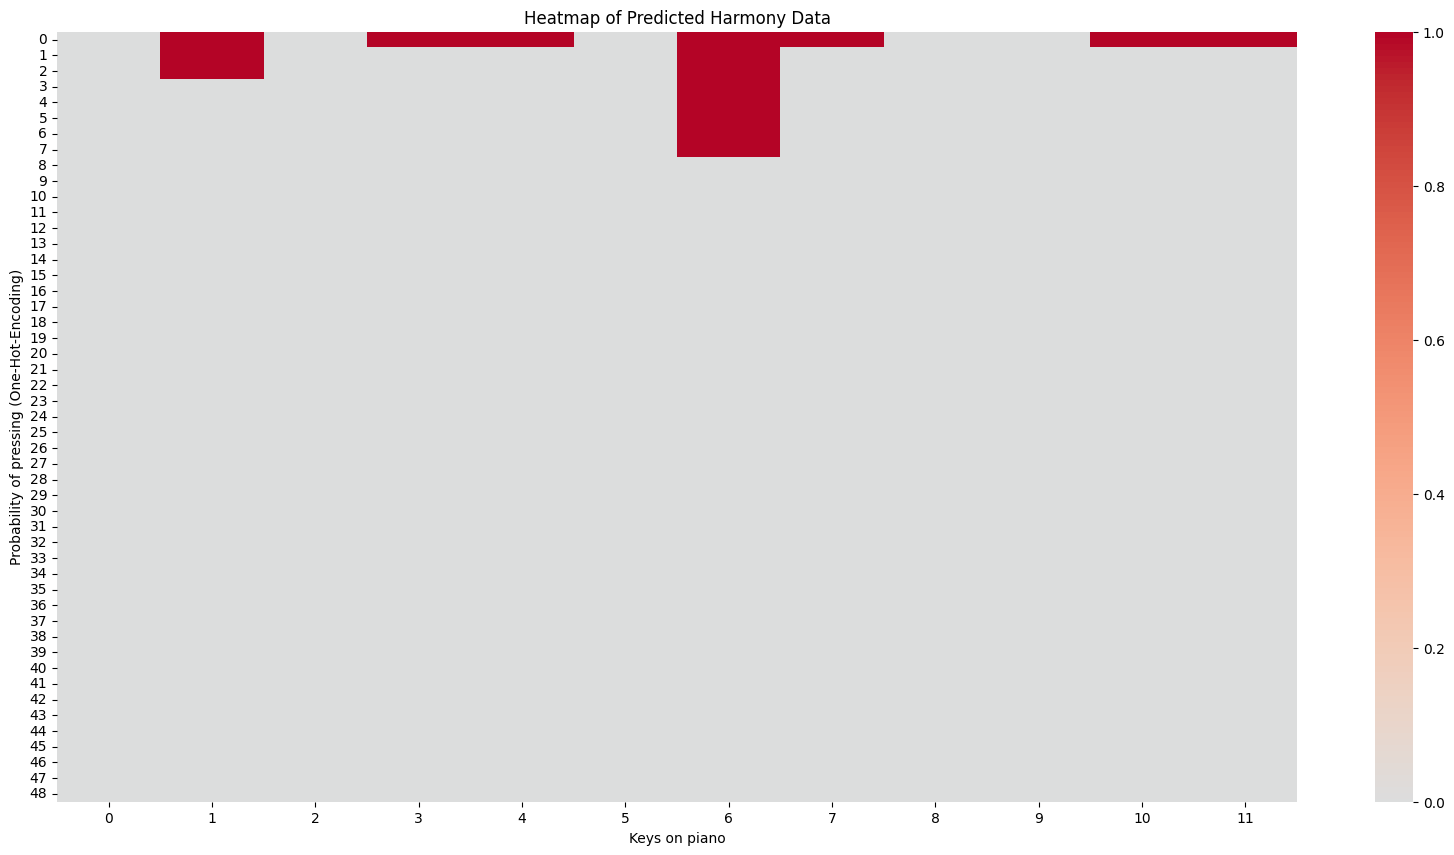

torch.Size([49, 12])
Output range: 0.0003708321019075811 0.14991290867328644
<class 'numpy.ndarray'>


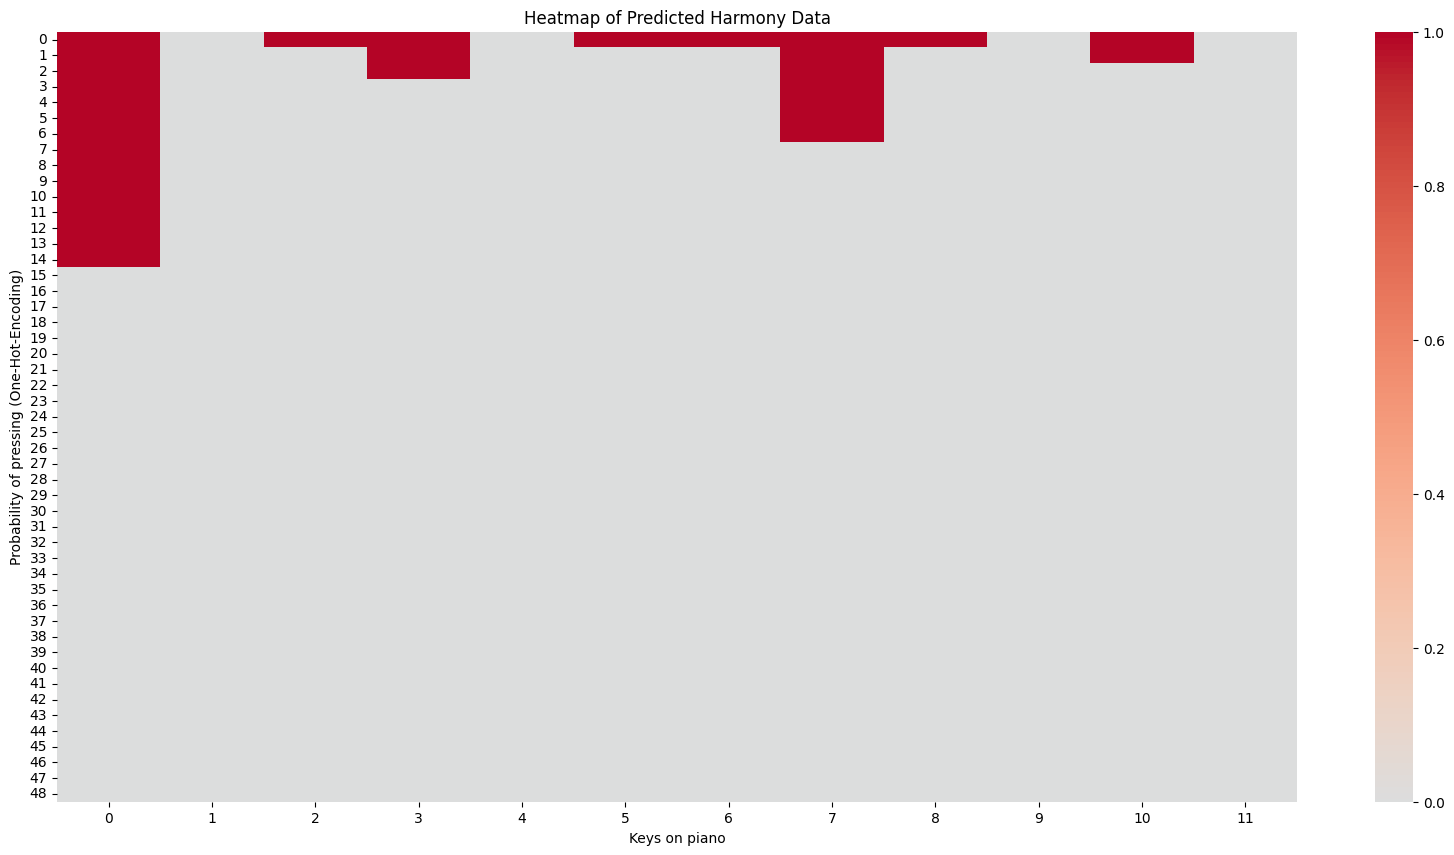

torch.Size([49, 12])
Output range: 0.00022561330115422606 0.20585109293460846
<class 'numpy.ndarray'>


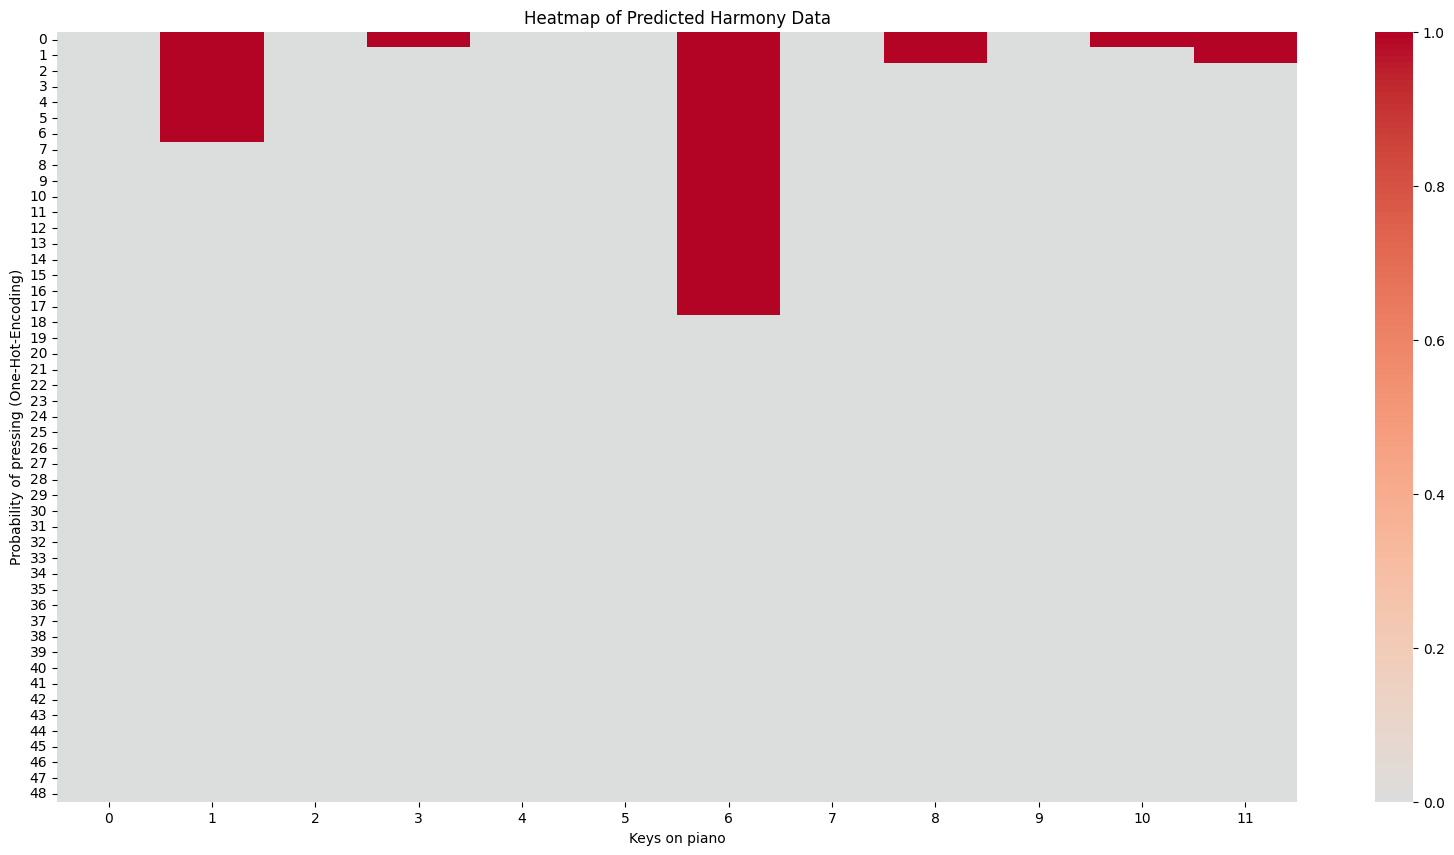

torch.Size([49, 12])
Output range: 0.0001201494233100675 0.16805022954940796
<class 'numpy.ndarray'>


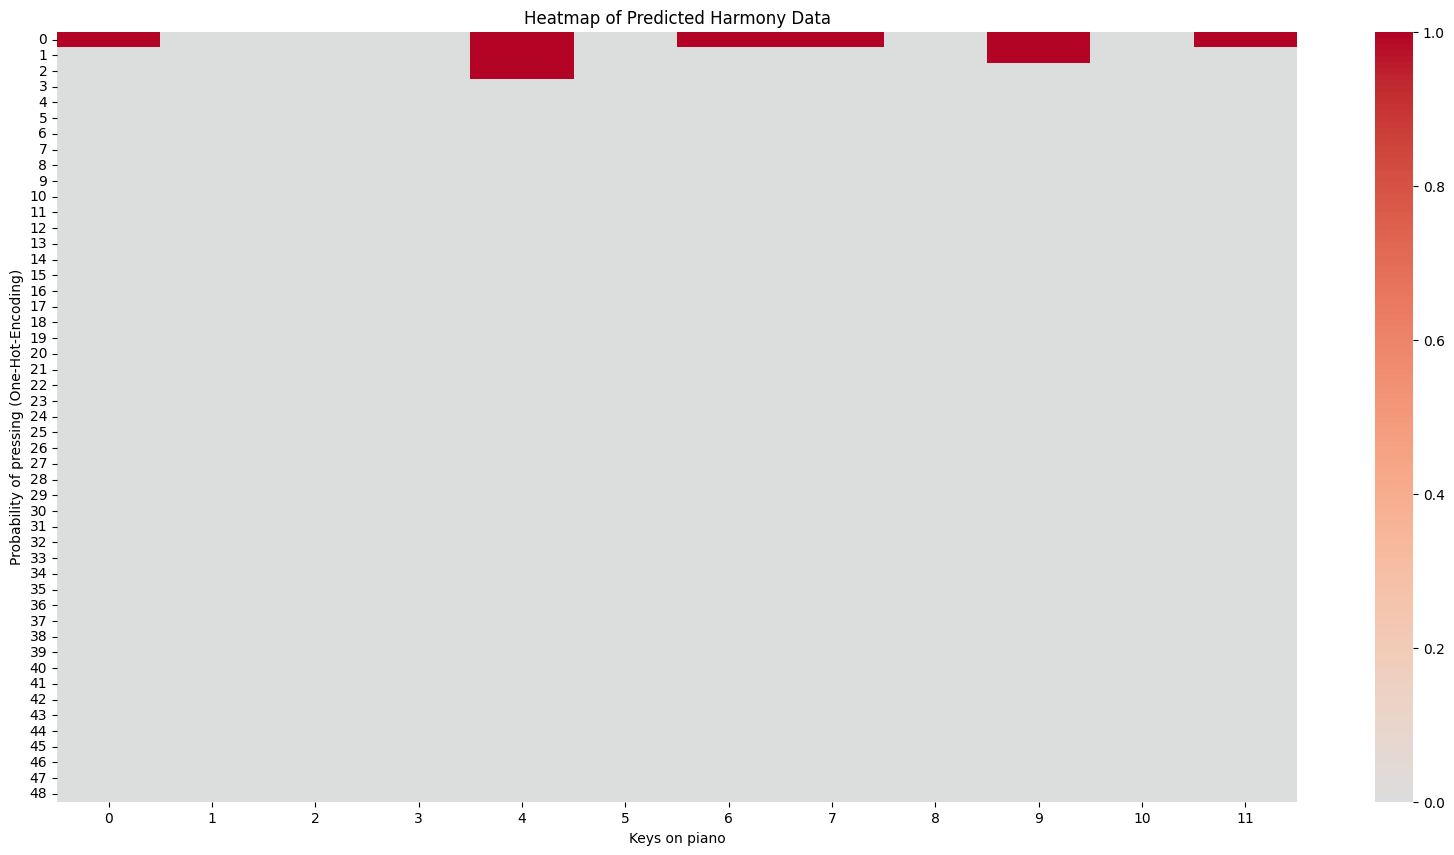

torch.Size([49, 12])
Output range: 0.0013377813156694174 0.11746194958686829
<class 'numpy.ndarray'>


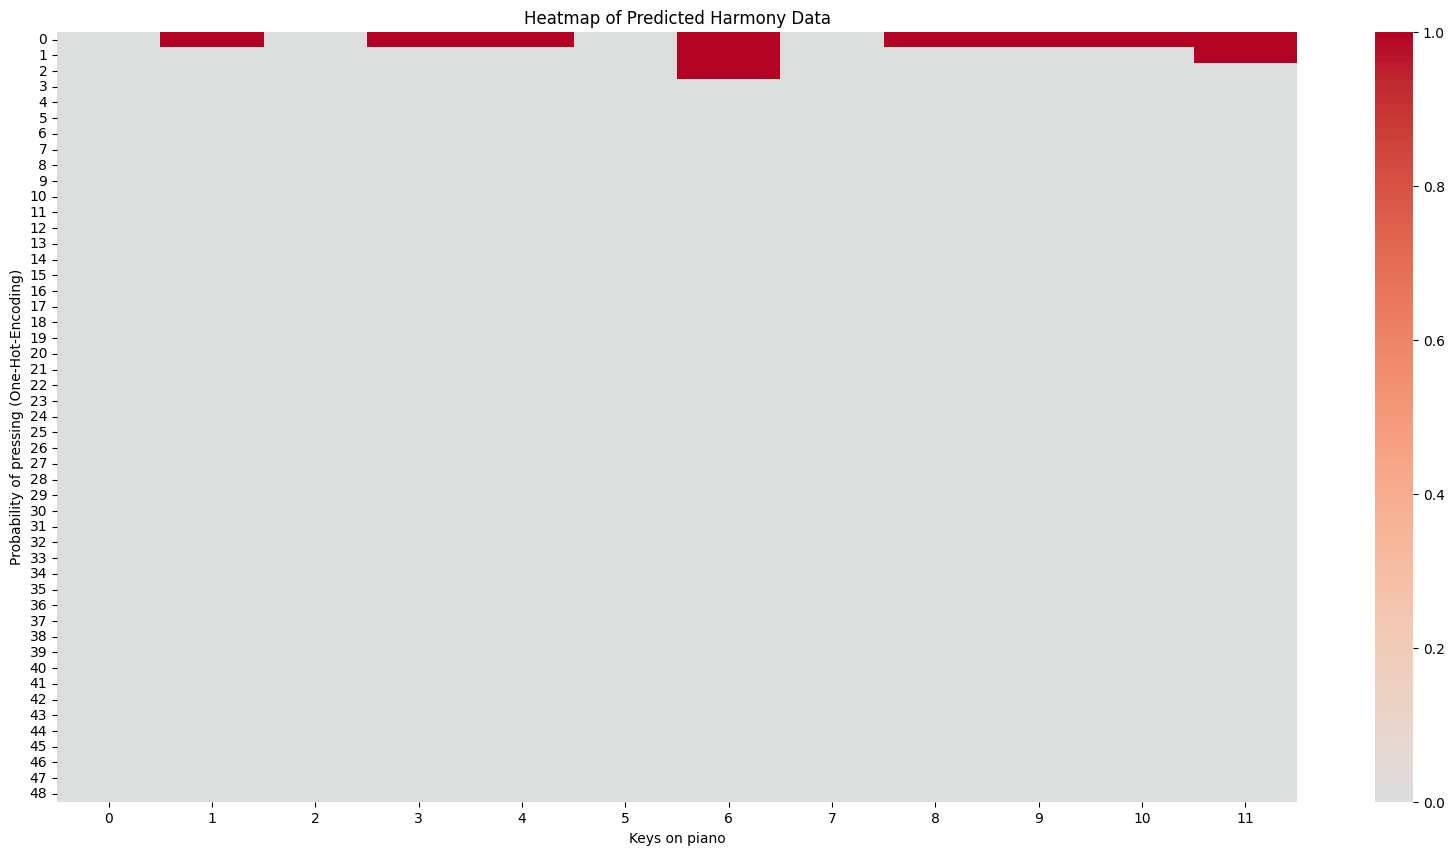

torch.Size([49, 12])
Output range: 0.0005942425923421979 0.15320979058742523
<class 'numpy.ndarray'>


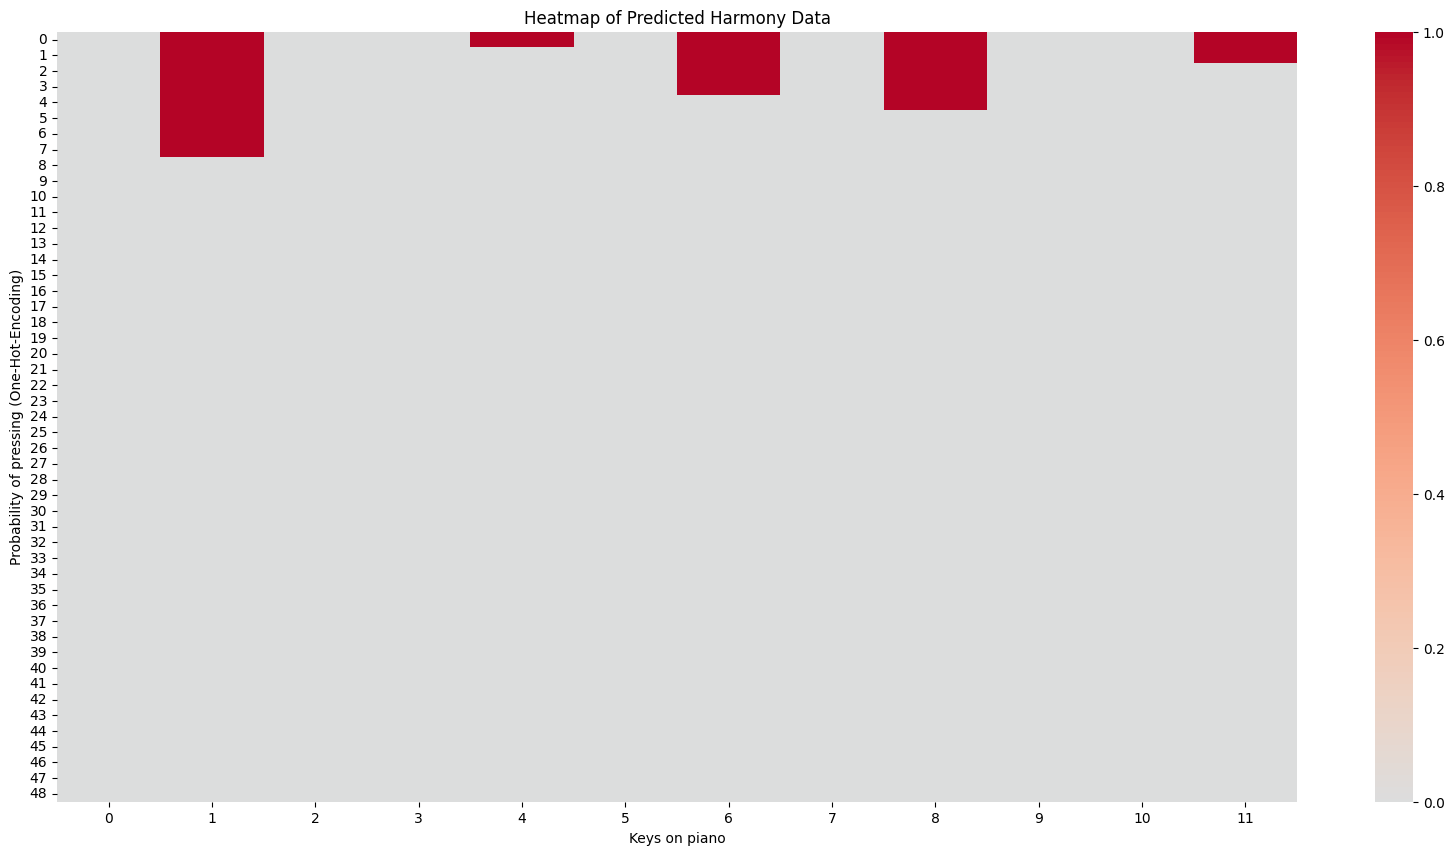

In [51]:
threshold = 0.05 

for output_sequence in predicted_sequence:
    print(output_sequence.shape)
    print("Output range:", torch.min(output_sequence).item(), torch.max(output_sequence).item())
    
    # apply threshold value
    # Apply thresholding
    output_sequence = (output_sequence >= threshold).float()
    
    # move to cpu for conversion
    output_sequence = output_sequence.cpu().numpy()
    print(type(output_sequence))
    
    printHeatmap(output_sequence, 0.002, 0, 1)

# Conclusion

Funktioniert im generellen nicht wirklich gut.

Probleme:

- Es werden nur 0 bis 7 Tokens vorhergesagt, obwohl eig. 50 tokens vorhergesagt werden sollen und auch auf mehr trainiert wird.
- Die Töne, die gespielt werden passen musikalisch nicht gut zusammen
- Er ist sich generell für alle töne sehr unsicher: output range nach sigmoid ist meistens zwischen 0 und 0.15

Potentielle Ursachen:

- Ich mache sehr wahrscheinlich einen Fehler beim Training mit memory und Target, da beim Decoder only ja der output vom letzten Step an den output angehängt und als input für den nächsten step verwendet wird. -> Autoregressiv
    - -> Wie soll ich dann die Vorhersage für die linke hand von der Rechten Hand machen? -> ist ja dann keine Übersetzung mehr, sondern Die Tokenvorhersage. Aber ich brauche ja die linke hand (+ evtl. rechte hand als input) -> und muss die Rechte hand vorhersagen. wie ist das dann mit der Vorhersage von nur der linken hand? -> oder doch lieber ganze sequenz vorhersagen 
- Der Decoder only Transformer generiert normalerweise nur 1 Token auf einmal -> ich habe evtl falschen Ansatz
- Ich mache generell irgendwo einen Fehler in der Transformerstruktur
- Das training passt nicht für einen Encoder-decoder Only -> Ich mache ja nicht wirklich eine sequentielle vorhersage sondern versuche quasi eher eine Übersetzung -> von rechter auf linke hand
- Die Snapshots müssen irgendwie anders tokenized werden. -> in allen textgenerierungstasks ist die eingabesquenz vor dem embedding geringer -> nur zahlen anstatt einem Vektor -> evtl. eigenen Tokenizer schreiben?
- **Keine eigene Kostenfunktion**
- inferenz muss anders gemacht werden
- Ist sigmoid-funktion im forward schritt wirklich notwendig oder am besten erst ganz am schluss